# Сборный проект № 2. Восстановление золота из руды

## Описание проекта
Золотообрабатывающей компании требуется механизм, позволяющий спрогнозировать насколько эффективным будет разработанный технологический процесс обработки золота, чтобы принять решение о целесообразности его внедрения. 

###  Цель проекта
1. Создать модель, которая на основании исследования исторических данных о результатах обработки сырья (характеристики сырья, настройки оборудования, качество итоговых продуктов) обеспечит предсказание эффективности золотообработки на двух стадиях (после флотации и после итоговой очистки). 2. 2. Показателем качества модели принять sMAPE, которую по-возможности минимизировать.

###  Задачи проекта
- Изучить распределение признаков
- Реализовать алгоритм расчета эффективности обагощения
- Сравнить распределений размеров гранул на обучающей и тестовой выборках
- Построить модель(и) регрессии для предсказания эффективности отчистки 
- Подобрать модель(и) используя sMAPE методом кроссвалидации для снижения рисков переобучения
- Проверить модель(и) на тестовой выборке.

###  Этапы проекта:
- Исследование данных:
    - загрузка данных
    - изучение данных (что означают столбцы, к каким этапам обработки относятся)
    - оценка данных (формы, типы, другое)
- Предобработка данных:
    - проверка и переименование названий столбцов
    - проверка и заполнение пропусков
    - проверка на дубликаты
    - проверка на мультиколлинеарность (выявление коррелированных столбцов, выборочное исключение)
    - выявление аномальных значений
    - стратификация по этапам обработки (при необходимости)
    - обработка даты
    - объединение всех ДФ в единый словарь (для автоматизации)
- Исследование данных на предмет применимости для машинного обучения
    - изучение признаков и целевых показателей
    - формиование списков параметров для первой(после флотации) и второй (после финальной очистки) моделей 
    - сравнение признаков в тестовой и тренировочной выборках (размер гранул)
    - анализ суммарных концентраций, обработка аномальных значений
    - нормализация данных (стандартизация)
- Машинное обучение с учителем
    - определение функции, расчитывающей sMAPE
    - подготовка решателя
    - подготовка функции, реализующей выбор лучщих гиперпараметров с использованием итерирования и кроссвалидации
    - перебор моделей регрессии с обучением на разных выборках (с/без стандартизации, с/без корреляции)
    - выбор оптимальной моделии и гиперпараметров
    - проверка моделей на тестовой выборке
    - расчет финального sMAPE
    

###  Описание данных
- Файлы данных
    - /datasets/gold_recovery_train_new.csv. Скачать датасет
    - /datasets/gold_recovery_test_new.csv. Скачать датасет
    - /datasets/gold_recovery_full_new.csv. Скачать датасет

- Целевые признаки
    - эффективность обагощения после флотации
    - эффективность обагощения после финальной отчистки
    
- Независимые признаки:
    - концентрации металлов во входном сырье для этапа флотации (rougher input ),
    - данные о размере гранул сырья для этапа флотации (feed size),
    - данные о реагентах (Xanthate, Sulphate, Depressant)
    - данные о настройках системы:
        - feed rate (скорость подачи)
        - fluid levels (уровень жидкости)
        - air amount (объем воздуха)

- Названия этапов обработки:
    - rougher — флотация
    - primary_cleaner — первичная очистка
    - secondary_cleaner — вторичная очистка
    - final — финальные характеристики

- Названия типов сырья (в зависимости от стадии):
    - input — поставляется на вход этапа
    - output — появляется на выходе этапа
    - tail — хвосты (ненужные очистки после этапа обработки)

## Загрузка библиотек и объявление глобальных переменных

In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Загрузка библиотек
import itertools
from collections import Counter
import copy
from itertools import combinations
from tqdm import tqdm
from pathlib import Path

#ДС библиотеки
import pandas as pd
import numpy as np
from scipy.stats import norm

#Графики
import seaborn as sns
import matplotlib.pyplot as plt

#МЛ библиотеки
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

#Модели
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Контстанты
RAMDOM_STATE = 1945
plt.style.use('classic')

## Определение функций

In [ ]:
#Функция для заполнения пропусков скользящим средним с окном, равным N часов
def castom_fill_na(data, N, sort_col):
    #Сортируем ДФ по дате
    data = data.sort_values(by = sort_col)
    #Итерируем по колонкам сортированного по дате датасета
    for col in data.columns:
        try:
            data[col] = data[col].fillna(\
                data[col].rolling(window = N, min_periods = 1).median())
        except:
            print(f'Пропуски в столбце {col} не заполнены')
    return data

In [ ]:
""" Семейство функций для расчета метрик и качества обогощения"""

#Функция расчета эффективности обагощения
def calc_recovery(df_row, input_r, output_r, tail_r):
    if (df_row[input_r] * (df_row[output_r] - df_row[tail_r])) == 0:
        recovery = 0
    else:
        recovery = 100*(df_row[output_r] * (df_row[input_r] - df_row[tail_r]))/ \
                   (df_row[input_r] * (df_row[output_r] - df_row[tail_r]))
    return abs(recovery)

# Функция для расчета метрики sMAPE
def calc_sMAPE(target, predict):
    sum_mape = 0
    if len(target) != len(predict):
        raise ValueError
    if type(target) == pd.Series and type(predict) == pd.Series:
        print('series')
        sum_mape = (200*abs(target - predict)/(abs(target) + abs(predict))).sum()
    else:
        sum_mape = 200*sum(abs(target - predict)/(abs(target) + abs(predict)))
          
    smape = sum_mape/len(target)
    return smape

#Функция расчета итогового sMAPE
def calc_final_sMAPE(sMAPE_1, sMAPE_3):
    return sMAPE_1*0.25 + sMAPE_3*0.75   

#Функция для рассчета суммарных концентраций
def calc_sum_density(data_con):
    #Суммарная концентрация на этапе СЫРЬЯ (перед флотацией)
    data_con['input_all'] = \
    data_con['1_input_au'] + data_con['1_input_ag'] + \
    data_con['1_input_pb'] + data_con['1_input_sol']
    #Суммарная концентрация на этапе ЧЕРНОВОГО КОНЦЕНТРАТА (после флотации)
    data_con['rough_output'] = \
    data_con['1_out_2_in_output_ag'] + data_con['1_out_2_in_output_pb'] + \
    data_con['1_out_2_in_output_sol'] + data_con['1_out_2_in_output_sol']
    #Суммарная концентрация на этапе после первично отчистки 
    data_con['first_clean_output'] = \
    data_con['2_out_3_in_output_ag'] + data_con['2_out_3_in_output_pb'] + \
    data_con['2_out_3_in_output_sol'] + data_con['2_out_3_in_output_sol']
    #Суммарная концентрация выходного продукта (после второй отчистки)
    data_con['output_all'] =\
    data_con['3_output_au'] + data_con['3_output_ag'] + \
    data_con['3_output_pb'] + data_con['3_output_sol']
    return data_con 

In [ ]:
""" Семейство функция для оценки мультиколлинеарности"""

#Функция, которая находит максимально часто задействованный в корреляции столбец 
#и список столбцов, с ним коррелированных
#На входпринимает список названий столбцов, которые надо проверить на корреляцию
def calc_max_corr_col(list_of_cols, df):
    #Находим все комбинации столбцов
    col_combs = list(itertools.combinations(list_of_cols, 2))
    #Задаем списки для всех коррелированных столбцов
    col_comb_with_corr = []
    all_cols_with_corr = []
    new_list = []
    
    for col_comb in col_combs:
        try:
            corr_value = df[col_comb[0]].corr(df[col_comb[1]])
            #Если корреляция выше порога добавляем столбцы в списки коррелированных
            if abs(corr_value) > 0.7:
                col_comb_with_corr.append([corr_value, col_comb[0], col_comb[1]])
                all_cols_with_corr.append(col_comb[0])
                all_cols_with_corr.append(col_comb[1])
            
        except:
            pass

    #Считаем количество вхождений каждого столбца в списки коррелированных
    count = Counter(all_cols_with_corr)
     
    #Ищем столбец, наиболее часто встреччающийся в списке коррелированных
    try:
        max_corr_col = max(count, key=count.get)
    except:
        return None
    
    #Формируем список столбцов, с которыми он коррелирован
    for comb in col_comb_with_corr:
        if comb[1] == max_corr_col:
            new_list.append(comb[2])
        elif comb[2] == max_corr_col:
            new_list.append(comb[1])
        else:
            pass
 
    friends = {max_corr_col:  new_list}
   
    #Возвращаем название столбца, число его вхождений в список коррелированных, его друзей по корреляции
    return (max_corr_col, count[max_corr_col], friends) 


 #Функция, которая определяет список мультиколленеарных столбцов
def calc_corr_cols(list_of_cols, df):
    #Список столбцов на удаление из списка комбинаций
    list_of_cols_for_drop = []
    #Список столбцов-друзей максимально коррелированныхстолбцов
    list_of_friends = []
    #Максимальное количество итераций 
    number_iters = len(list_of_cols)
    
    for step in range(number_iters):
        #Вычисляем наиболее часто коррелированный столбец и его друзей-корелянтов
        results = calc_max_corr_col(list_of_cols, df)
        if not results:
            break
        (max_corr_col, max_corr_col_count, friens) = results
        
        #Если количество столбцов, с которым коррелирован самый коррелированный меньше 1 выходим из цикла
        if max_corr_col_count < 1:
            break
        else:
            #Заисываем столбец в список на удаление
            list_of_cols_for_drop.append(max_corr_col)            
            #Убираем его из списка для построения комбинаций
            list_of_cols.remove(max_corr_col)
            #Фиксируем друзей-коррелянтов
            list_of_friends.append(friens)
    return (list_of_cols_for_drop, list_of_friends)   
    

In [ ]:
""" Семейство функций для реализации подбора гиперпараметров аля GridSearch """

#Функция для подбора всех возможных комбинаций заданных параметров. 
#Принимает на вход словарь с параметрами, которые надо проверить 
#({'имя 1-го параметра': [список для перебора], 'имя 2-го параметра': [список для перебора]})
#Возбращает сисок со словарями со всеми возможными комбинациями 
#[{'имя 1-го параметра': значение 1-1, 'имя 2-го параметра': значение 2-1'},
#{'имя 1-го параметра': значение 1-2, 'имя 2-го параметра': значение 2-1'},]
def calc_param_comb(dict_with_params):
    all_values = []
    list_for_del = []
    
    #Формируем список всех параметров
    for key, list_with_param in tqdm(dict_with_params.items()):
        #if isinstance(list_with_param, list):
            #print(list_with_param)
        if not isinstance(list_with_param, list):
            list_with_param = [list_with_param,]
            dict_with_params[key] = list_with_param
        all_values.extend(list(list_with_param))
         
    
    #Просчитываем все возможные комбинации на основании полного множества    
    combinatin = set(combinations(all_values, len(dict_with_params)))
    
    #Формируем список комбинаций, в которых использованы комбинации, где на позицияхиспользованы элементы, \
    #которых нет в спискахдля этой позиции
    for comb_item in tqdm(combinatin):
        for index_param, list_with_param in enumerate(dict_with_params.values()):
                      
            if comb_item[index_param] not in list_with_param:
                list_for_del.append(comb_item)
    
    #Удаляем неправильные комбинации
    for list_fd in set(list_for_del):
        combinatin.remove(list_fd)
     
    #Формируем список словарей с параметрами, которые будем последовательно передавать на вход вызываемой функции 
    combinatin_dict_list = []
    for comb in combinatin:
        dict_list = {}
        for ind in range(len(dict_with_params)):
            prom_dict = {list(dict_with_params.keys())[ind]: comb[ind]}
            dict_list = {**dict_list, **prom_dict}
        combinatin_dict_list.append(dict_list)
   
    return combinatin_dict_list

#Функция для вызова одного из методов для создания моделей предсказаний
#Принимает на вход объект метода и словарь вида
#({'имя 1-го параметра': значение, 'имя 2-го параметра': значение, ...})
def run_func(func, **kwargs):
    #Словарь параметров для методов, чтобы функция знала, какие параметры изымать из kwargs
    func_dict = {#DecisionTreeClassifier: ['random_state', 'max_depth', 'min_samples_split', \
                 #                         'min_samples_leaf', 'criterion', 'splitter',\
                 #                         'max_features'], \
                 #RandomForestClassifier: ['random_state', 'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf'],\
                 #LinearDiscriminantAnalysis: [],
                 #GaussianNB: [],
                 #SVC: ['kernel', 'degree', 'gamma', 'decision_function_shape'],
                 #Модели регрессии
                 #LogisticRegression: ['solver', 'max_iter'],
                 Lasso: ['random_state', 'alpha', 'max_iter', 'tol'],
                 LinearRegression: ['n_jobs'],
                 DecisionTreeRegressor: ['random_state','max_depth', 'min_samples_split', 'min_samples_leaf'],  
                 ElasticNet: ['alpha', 'random_state'],
                 Ridge: ['alpha', 'solver', 'random_state'],
                };
    
    #Измаем из kwargs нужные для вызываемого метода параметры и записываем их в новый словарь. 
    final_kwargs = {param: kwargs.get(param) for param in func_dict[func]}
    #Возвращаем функцию, которой на вход передан параматр random_state и словарь с параметрами 
    return(func(**final_kwargs))

#Функция, которая обучает принятую на вход модель, делает предсказание и вычисляет метрику качества
def munipul_model(model, _train_feachers, _train_target):
    #Обучаем модель
    model.fit(_train_feachers, _train_target)
    #Делаем предсазание на тренировочной выборке
    train_predict = model.predict(_train_feachers)
    #Вычисляем sMAPE на тренировочной выборке
    sMAPE_train = calc_sMAPE(_train_target, train_predict)
    
    return (sMAPE_train, model)  

#Функция, которая принимает на вход название метода для модели, обучающую выборку, выборку, на которой надо сделать предикт и
#словарь с параметрами, которые нужно перебрать 
#({'имя 1-го параметра': [список для перебора], 'имя 2-го параметра': [список для перебора]})
def find_best_model(model_func,\
                    _train_feachers, _train_target, cast_scorer, use_cross_val = True, **kwargs):
    max_sMAPE = 10000000 
    best_model = None
    best_sMAPE_train = 10000000
    best_params = None

   
    #Расчитываем все возможные комбинации параметров
    combinations = calc_param_comb(kwargs)
 
    #Для каждой строим модель, комбинации расчитываем accuracy 
    for comb in tqdm(combinations):
        model = run_func(model_func, **comb)
        if use_cross_val:
            sMAPE_list = \
            cross_val_score(model, _train_feachers, _train_target,\
                            cv = 3, scoring = cast_scorer, n_jobs=-1, verbose=10)
            sMAPE_list = abs(sMAPE_list[~np.isnan(sMAPE_list)])
            if not len(sMAPE_list):
                return (None, None)
            sMAPE = sum(sMAPE_list)/len(sMAPE_list)
        else:
            (sMAPE, model) = munipul_model(model, _train_feachers, _train_target)
                        
        #Ищем лучшую модель
        if sMAPE < max_sMAPE:
            max_sMAPE = sMAPE
            best_model = model
            best_sMAPE_train = sMAPE
            best_params = comb
   
    print(f'''Лучщая модель исследуемого метода : {model_func} показала эффективность (sMAPE):
     - на тренировочной выборке {best_sMAPE_train} с параметрами {best_params} ''')
   
    return (best_model, best_params)
    

In [ ]:
""" Семейство функций для визуализации """



' Семейство функций для визуализации '

## Загрузка данных

In [ ]:
# Считываем данные
file_path_1 = Path('gold_recovery_train_new.csv').absolute()
file_path_2 = Path('gold_recovery_test_new.csv').absolute()
file_path_3 = Path('gold_recovery_full_new.csv').absolute()
try:
    train = pd.read_csv(file_path_1)
    test = pd.read_csv(file_path_2)
    full = pd.read_csv(file_path_3)
except:
    train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/gold_industry_train.csv")
    test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/gold_industry_test.csv")
    full = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/gold_industry_full.csv")

In [ ]:
#Записываем данные в словарь, чтобы по ним было легче итерировать
dict_keys = [
    "data",                #ДФ со всеми даными по ДФ
    "features",            #ДФ с признаками 
    "target",              #Сериес с целевым признаком
    ]

#Формируем пустой словарь 
ddict = { idx: {key: None for key in dict_keys} for idx in ['train','test','full']}

#Записываем данные в словарь для автоматизации повторений

ddict["train"]["data"] = train
ddict["test"]["data"] = test
ddict["full"]["data"] = full

## Знакомство с данными и первичная обработка

### Изучение столбцов

In [ ]:
#Знакомство с данными
for df in ddict.values():
    display(df["data"].info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


None

В каждом из представленных датасетов присутсвует от 52 (для тестового ДФ) до 86 столбцов. Эти данные характеризуют этапы обработки смеси металлов с целью обогащения в ней концентрации золота. Разные столбцы относятся к разным этапам и могут быть разбиты на следующие смысловые группы:
- концентрации металлов в входном сырье для каждого этапа,
- концентрации металлов в продукте после обработки для каждого этапа,
- концентрации металлов в хвостах после обработки для каждого этапа,
- данные о реагентах
- данные о настройках системы
- расчетные данные.

При этом в тестовой выборке недоступны данные о:
-  концентрации металлов в продукте после обработки для этапов:
     - флотации
     - первичной очистки
     - вторичной очистки
- концентрации металлов в хвостах после обработки для этапов:
     - флотации
     - первичной очистки
     - вторичной очистки
- концентрации металлов в входном сырье для этапов:
     - первичной очистки
     - вторичной очистки

Разумно предположить, что все эти данные должны рассчитываться на основании данных-признаков, к которым следует отнести:
- данные о реагентах
- данные о настройках системы
- данные о концентрации металлов в исходном сырье (до флотации)

При этом для каждого из этапов обработки данные входные и выходные концентрации будут разными. С учетом заявленного тех.процесса и описанных соображений мысленно разделим все колонки ДФ на 4 этапа и переименуем их добавив соответствующие префиксы:
1 - для этапа флотации
2 - для этапа первичной обработки
3 - для этапа вторичной обработки
4 - для итоговых данных

### Переименование столбцов

In [ ]:
revert_dict_for_rename = {
#расчетные значения (не нужны)  
'1_sulfate': 'rougher.calculation.sulfate_to_au_concentrate',
'1_fb10_sulfate_calc': 'rougher.calculation.floatbank10_sulfate_to_au_feed',
'1_fb11_sulfate_calc': 'rougher.calculation.floatbank11_sulfate_to_au_feed',
'1_au_pb_ratio': 'rougher.calculation.au_pb_ratio',
#входные данные сырья для флотации
'1_input_ag':'rougher.input.feed_ag',
'1_input_rate':'rougher.input.feed_rate',
'1_input_ag': 'rougher.input.feed_ag',
'1_input_size': 'rougher.input.feed_size',
'1_input_sol': 'rougher.input.feed_sol',
'1_input_au': 'rougher.input.feed_au',
'1_input_pb': 'rougher.input.feed_pb',
#настройки реактивов для флотации
'1_fb10_sulfate': 'rougher.input.floatbank10_sulfate',
'1_fb10_xanthate': 'rougher.input.floatbank10_xanthate',
'1_fb11_sulfate': 'rougher.input.floatbank11_sulfate',
'1_fb11_xanthate': 'rougher.input.floatbank11_xanthate',
#настройки системы для флотации
'1_fb10_a_air': 'rougher.state.floatbank10_a_air', 
'1_fb10_a_level': 'rougher.state.floatbank10_a_level', 
'1_fb10_b_air': 'rougher.state.floatbank10_b_air', 
'1_fb10_b_level': 'rougher.state.floatbank10_b_level', 
'1_fb10_c_air': 'rougher.state.floatbank10_c_air',
'1_fb10_c_level': 'rougher.state.floatbank10_c_level',
'1_fb10_d_air': 'rougher.state.floatbank10_d_air', 
'1_fb10_d_level': 'rougher.state.floatbank10_d_level',
'1_fb10_e_air': 'rougher.state.floatbank10_e_air', 
'1_fb10_e_level': 'rougher.state.floatbank10_e_level',
'1_fb10_f_air': 'rougher.state.floatbank10_f_air', 
'1_fb10_f_level': 'rougher.state.floatbank10_f_level',
#хвосты после флотации
'1_tail_ag': 'rougher.output.tail_ag', 
'1_tail_au': 'rougher.output.tail_au', 
'1_tail_pb': 'rougher.output.tail_pb', 
'1_tail_sol': 'rougher.output.tail_sol', 
#продукты после флотации == сырье для первого этапа отчистки   
'1_out_2_in_output_ag': 'rougher.output.concentrate_ag',
'1_out_2_in_output_pb': 'rougher.output.concentrate_pb',
'1_out_2_in_output_sol': 'rougher.output.concentrate_sol',
'1_out_2_in_output_au': 'rougher.output.concentrate_au',
#ТАРГЕТ флотации
'1_recovery': 'rougher.output.recovery',    
#настройки реактивов для первой отчистки
'2_sulfate': 'primary_cleaner.input.sulfate',                      
'2_depressant':'primary_cleaner.input.depressant',                   
'2_input_size':'primary_cleaner.input.feed_size',                    
'2_xanthate' :'primary_cleaner.input.xanthate',                    
#настройки системы для первой очистки
'2_fb8_a_air' :'primary_cleaner.state.floatbank8_a_air',             
'2_fb8_a_level': 'primary_cleaner.state.floatbank8_a_level',          
'2_fb8_b_air': 'primary_cleaner.state.floatbank8_b_air',            
'2_fb8_b_level': 'primary_cleaner.state.floatbank8_b_level',          
'2_fb8_c_air' : 'primary_cleaner.state.floatbank8_c_air',           
'2_fb8_c_level': 'primary_cleaner.state.floatbank8_c_level',           
'2_fb8_d_air': 'primary_cleaner.state.floatbank8_d_air',            
'2_fb8_d_level': 'primary_cleaner.state.floatbank8_d_level', 
#хвосты после первой очистки   
'2_tail_ag': 'primary_cleaner.output.tail_ag',                    
'2_tail_pb': 'primary_cleaner.output.tail_pb',                    
'2_tail_sol': 'primary_cleaner.output.tail_sol',                    
'2_tail_au': 'primary_cleaner.output.tail_au',     
#продукты после первой очистки == сырье для второго этапа отчистки     
'2_out_3_in_output_ag': 'primary_cleaner.output.concentrate_ag',         
'2_out_3_in_output_pb': 'primary_cleaner.output.concentrate_pb',           
'2_out_3_in_output_sol': 'primary_cleaner.output.concentrate_sol',            
'2_out_3_in_output_au': 'primary_cleaner.output.concentrate_au',           
#настройки реактивов для второй отчистки
'3_fb2_a_air': 'secondary_cleaner.state.floatbank2_a_air',           
'3_fb2_a_level': 'secondary_cleaner.state.floatbank2_a_level',         
'3_fb2_b_air': 'secondary_cleaner.state.floatbank2_b_air',           
'3_fb2_b_level': 'secondary_cleaner.state.floatbank2_b_level',         
'3_fb3_a_air': 'secondary_cleaner.state.floatbank3_a_air',        
'3_fb3_a_level': 'secondary_cleaner.state.floatbank3_a_level',        
'3_fb3_b_air': 'secondary_cleaner.state.floatbank3_b_air',         
'3_fb3_b_level': 'secondary_cleaner.state.floatbank3_b_level',         
'3_fb4_a_air': 'secondary_cleaner.state.floatbank4_a_air',        
'3_fb4_a_level': 'secondary_cleaner.state.floatbank4_a_level',         
'3_fb4_b_air': 'secondary_cleaner.state.floatbank4_b_air',        
'3_fb4_b_level': 'secondary_cleaner.state.floatbank4_b_level',        
'3_fb5_a_air': 'secondary_cleaner.state.floatbank5_a_air',          
'3_fb5_a_level': 'secondary_cleaner.state.floatbank5_a_level',         
'3_fb5_b_air': 'secondary_cleaner.state.floatbank5_b_air',         
'3_fb5_b_level': 'secondary_cleaner.state.floatbank5_b_level',         
'3_fb6_a_air': 'secondary_cleaner.state.floatbank6_a_air',        
'3_fb6_a_level': 'secondary_cleaner.state.floatbank6_a_level',  
#хвосты после второй очистки  
'3_tail_ag': 'secondary_cleaner.output.tail_ag',                  
'3_tail_pb': 'secondary_cleaner.output.tail_pb',                
'3_tail_sol': 'secondary_cleaner.output.tail_sol',                 
'3_tail_au': 'secondary_cleaner.output.tail_au',                
#продукты после второй очистки == продукты окончательные 
'3_output_ag': 'final.output.concentrate_ag',
'3_output_pb': 'final.output.concentrate_pb',                    
'3_output_sol': 'final.output.concentrate_sol',                      
'3_output_au': 'final.output.concentrate_au',     
#суммарные хвосты после всех этапов      
'4_tail_pb': 'final.output.tail_pb',
'4_tail_sol': 'final.output.tail_sol',
'4_tail_au': 'final.output.tail_au',
'4_tail_ag': 'final.output.tail_ag',
#ТАРГЕТ финальный    
'4_recovery': 'final.output.recovery'}

dict_for_rename = {value: key for key, value in revert_dict_for_rename.items()}

In [ ]:
#Переименовываем столбцы
for item in ddict.values():
    item["data"] = item["data"].rename(columns = dict_for_rename)

### Удаление неинформативных столбцов

Удалим из ДФ неинформативные столбцы ('1_sulfate', '1_fb10_sulfate_calc', '1_fb11_sulfate_calc', '1_au_pb_ratio') . Они не являются информативными потому что:
1. Этих столбцов нет в тестовом ДФ, а по условию задачи мы можеи использовать только те независимые признаки, которые там есть.
2. По названиям очевидно, что это столбцы с калькуляцией, они получаются из других столбцов ДФ. Поэтому стоит предположить, что они были нужны инженерам для каких-то своих внутренних задач 

In [ ]:
#Расчтеные столбцы
calc_columns = ['1_sulfate', '1_fb10_sulfate_calc', '1_fb11_sulfate_calc', '1_au_pb_ratio']

#Удалим расчетные столбцы
for item in ddict.values():
    item["data"] = item["data"].drop(columns = calc_columns, errors = 'ignore')

### Обработка даты

In [ ]:
#Обработка даты для всех ДФ
for item in ddict.values():
    item["data"]["date"] = pd.to_datetime(item["data"]['date'],\
                                                   format = '%Y-%m-%d %H:%M:%S')

### Проверка на дубликаты

In [ ]:
#Проверка на дубликаты
for item in ddict.values():
    print(item["data"]["date"].duplicated().sum())

0
0
0


Так как поле дата не дублируется и при этом используется на всех этапах обработки, будем использовать его в качестве индекса

### Обработка пропусков

Так как данные тесно связаны по времени и согласно техническому заданию близкие по времени данные близки друг к другу по значениям заполним пропуски методом скользящего среднего с окном, равным 24 записям, что в условиях датасета равноценно одним суткам.

In [ ]:
ddict['train']['data'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 83 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14579 non-null  datetime64[ns]
 1   1_input_au             14579 non-null  float64       
 2   1_input_ag             14579 non-null  float64       
 3   1_input_pb             14507 non-null  float64       
 4   1_input_sol            14502 non-null  float64       
 5   1_input_rate           14572 non-null  float64       
 6   1_input_size           14478 non-null  float64       
 7   1_fb10_sulfate         14548 non-null  float64       
 8   1_fb10_xanthate        14572 non-null  float64       
 9   1_fb10_a_air           14579 non-null  float64       
 10  1_fb10_a_level         14579 non-null  float64       
 11  1_fb10_b_air           14579 non-null  float64       
 12  1_fb10_b_level         14579 non-null  float64       
 13  1

В ДФ выявлены существенное количество пропусков в следующих столбцах:
3_output_sol,
2_out_3_in_output_sol,
1_fb11_xanthate,
1_fb10_e_air,
3_tail_sol

Зафиксируем их распределения и статистики,  чтобы проконтролировать, что они не исказились при заполнении пропусков

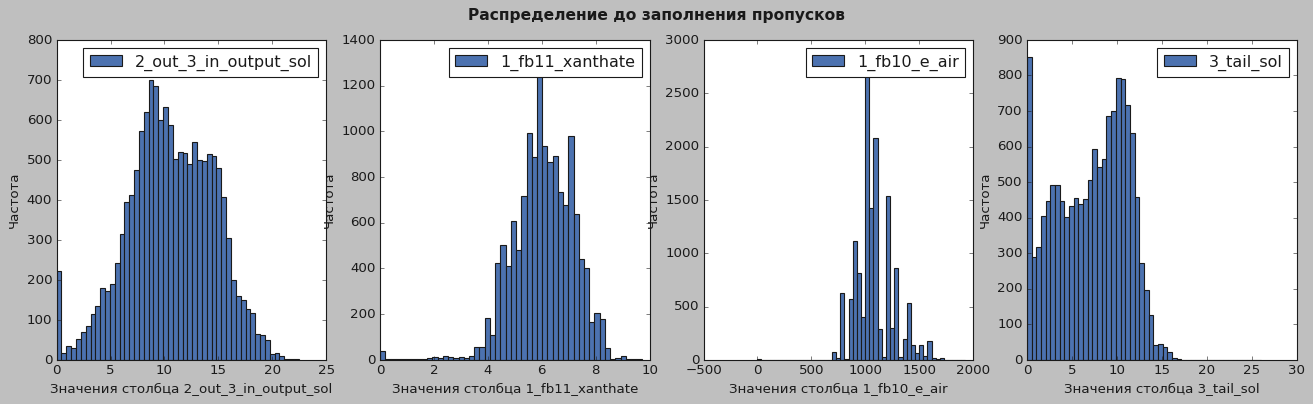

In [ ]:
cols_with_nan = ['2_out_3_in_output_sol', '1_fb11_xanthate', '1_fb10_e_air', '3_tail_sol']
fig, axes = plt.subplots(nrows = 1, ncols = 4, sharey = False, figsize = (20, 5))
# Заголовок фигуры
fig.suptitle('Распределение до заполнения пропусков', fontsize=14, fontweight='bold');
for idx, col in enumerate(cols_with_nan):
    ddict['train']['data']\
    .plot(kind = 'hist', y = col, bins = 50, ax = axes[idx]);
    axes[idx].set_xlabel(f'Значения столбца {col}')
    axes[idx].set_ylabel('Частота');
     

In [ ]:
#Заполняем пропуски скользящим средним с окном, равным суткам
for item in ddict.values():
    item["data"] = castom_fill_na(item["data"], 24, 'date')

Пропуски в столбце date не заполнены
Пропуски в столбце date не заполнены
Пропуски в столбце date не заполнены


In [ ]:
#Заполняем пропуски скользящим средним с окном, равным неделе
for item in ddict.values():
    item["data"] = castom_fill_na(item["data"], 24*7, 'date')

Пропуски в столбце date не заполнены
Пропуски в столбце date не заполнены
Пропуски в столбце date не заполнены


In [ ]:
#Проверяем, где остались пропуски
for item in ddict.values():
    print(item["data"].isna().sum().sum())

80
0
80


После обработки пропусков осталось 80 пропусков в тренировочном и полном ДФ. Это меньше 10 %, удалим их

In [ ]:
#Удаляем оставшиеся пропуски 
for item in ddict.values():
    item["data"] = item["data"].dropna()

In [ ]:
#Проверяем, где остались пропуски
for item in ddict.values():
    print(item["data"].isna().sum().sum())

0
0
0


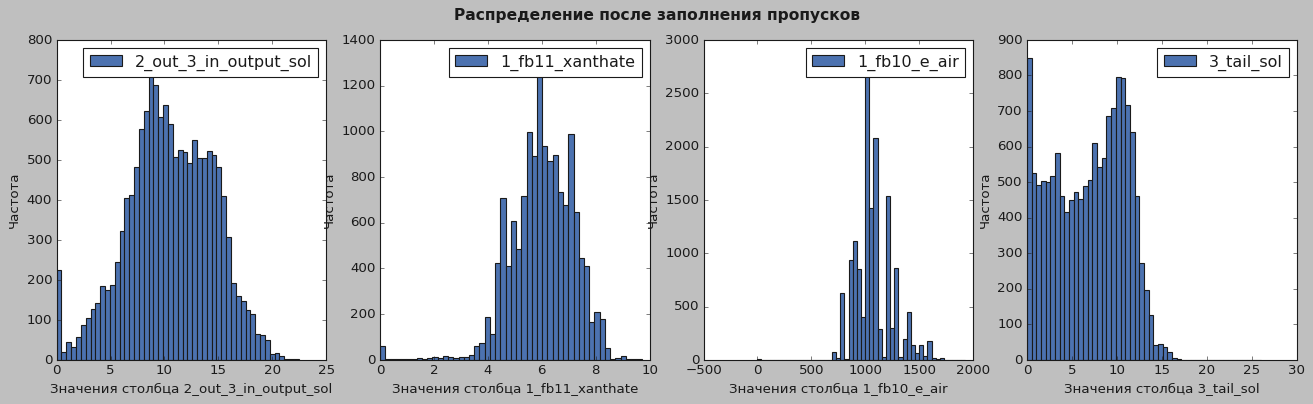

In [ ]:
cols_with_nan = ['2_out_3_in_output_sol', '1_fb11_xanthate', '1_fb10_e_air', '3_tail_sol']
fig, axes = plt.subplots(nrows = 1, ncols = 4, sharey = False, figsize = (20, 5))
# Заголовок фигуры
fig.suptitle('Распределение после заполнения пропусков', fontsize=14, fontweight='bold');
for idx, col in enumerate(cols_with_nan):
    ddict['train']['data']\
    .plot(kind = 'hist', y = col, bins = 50, ax = axes[idx]);
    axes[idx].set_xlabel(f'Значения столбца {col}')
    axes[idx].set_ylabel('Частота');

Форма распределений не исказилась, что позваляет принять выполнные изменения ДФ 

### Проверка на мультиколениарность

In [ ]:
#Определение коллинеарных столбцов
list_of_cols = list(ddict['train']['data'].columns)
list_of_cols_for_drop, list_of_friends = calc_corr_cols(list_of_cols, ddict['train']['data'])

In [ ]:
#Список всех коррелированных столбцов
display(list_of_cols_for_drop)

['1_fb10_b_air',
 '1_fb10_b_level',
 '1_fb10_c_air',
 '1_fb10_c_level',
 '3_fb4_a_air',
 '1_input_au',
 '1_fb10_d_air',
 '1_fb10_d_level',
 '1_out_2_in_output_sol',
 '1_tail_au',
 '2_fb8_a_air',
 '2_fb8_a_level',
 '3_fb5_a_level',
 '3_fb4_b_air',
 '1_input_ag',
 '1_input_pb',
 '1_fb10_sulfate',
 '1_fb10_xanthate',
 '1_fb10_e_air',
 '1_fb10_e_level',
 '1_out_2_in_output_ag',
 '2_fb8_b_air',
 '2_fb8_b_level',
 '2_out_3_in_output_ag',
 '2_tail_ag',
 '3_fb2_a_air',
 '3_fb2_a_level',
 '3_fb3_a_air',
 '3_fb3_a_level',
 '3_fb5_a_air']

In [ ]:
#Список всех коррелированных столбцов с указанием столбцов, с которыми они коррелированы 
display(list_of_friends)

[{'1_fb10_b_air': ['1_fb10_c_air',
   '1_fb10_d_air',
   '1_fb10_e_air',
   '1_fb10_f_air']},
 {'1_fb10_b_level': ['1_fb10_c_level',
   '1_fb10_d_level',
   '1_fb10_e_level',
   '1_fb10_f_level']},
 {'1_fb10_c_air': ['1_fb10_d_air', '1_fb10_e_air', '1_fb10_f_air']},
 {'1_fb10_c_level': ['1_fb10_d_level', '1_fb10_e_level', '1_fb10_f_level']},
 {'3_fb4_a_air': ['3_fb4_b_air', '3_fb5_a_air', '3_fb5_b_air']},
 {'1_input_au': ['1_input_ag', '1_input_pb']},
 {'1_fb10_d_air': ['1_fb10_e_air', '1_fb10_f_air']},
 {'1_fb10_d_level': ['1_fb10_e_level', '1_fb10_f_level']},
 {'1_out_2_in_output_sol': ['1_out_2_in_output_au', '1_out_2_in_output_ag']},
 {'1_tail_au': ['1_tail_ag', '1_tail_pb']},
 {'2_fb8_a_air': ['2_fb8_b_air', '2_fb8_c_air']},
 {'2_fb8_a_level': ['2_fb8_b_level', '2_fb8_c_level']},
 {'3_fb5_a_level': ['3_fb4_a_level', '3_fb5_b_level']},
 {'3_fb4_b_air': ['3_fb5_a_air', '3_fb5_b_air']},
 {'1_input_ag': ['4_tail_ag']},
 {'1_input_pb': ['4_tail_pb']},
 {'1_fb10_sulfate': ['1_fb11_sulfa

С учетом полученных списков комбинаций(групп) мультикоррелированных столбцов можно отметить, что корреляция характерна для столбцов, опреледеляющих признаки внутри одного эатапа обработки. То есть корреляция между столбцами, определяющими разные этапы обработки смеси в ДФ отсутсвуют. 

Так как для корректного функционирования линейных моделей машинного обучения желательно, чтобы в ДФ мультиколеарность отсутсвовала сделаем следующее:
1. Сохраним в словаре ДФ c полным набором столбцов - ключ data
2. Сохраним в словаре ДФ полностью отчищенный от мультиколлеарности - ключ data_no_corr

In [ ]:
#Правим список столбцов на удаление вручную
corr_columns = [
 '1_fb10_b_air',
 '1_fb10_b_level',
 '3_fb4_b_air',
 '3_fb4_a_level',
 '2_fb8_b_level',
 '1_fb10_c_air',
 '1_fb10_c_level',
 '3_fb5_a_air',
 '2_fb8_a_air',
 '1_fb10_d_air',
 '1_fb10_d_level',
 '3_fb5_b_air',
 '2_fb8_a_level',
 '2_fb8_b_air',
 '1_fb10_sulfate',
 '1_fb10_xanthate',
 '1_fb10_e_air',
 '1_fb10_e_level',
 '3_fb2_a_air',
 '3_fb2_a_level',
 '3_fb5_a_level']

In [ ]:
#Удалим коррелированные столбцы
for item in ddict.values():
    item["data_no_corr"] = item["data"].drop(columns = corr_columns, errors = 'ignore')

<ipython-input-190-c2ad590a99bf>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  upp_mat = np.triu(ddict['train']['data_no_corr'].corr())
<ipython-input-190-c2ad590a99bf>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(ddict['train']['data_no_corr'].corr(),\


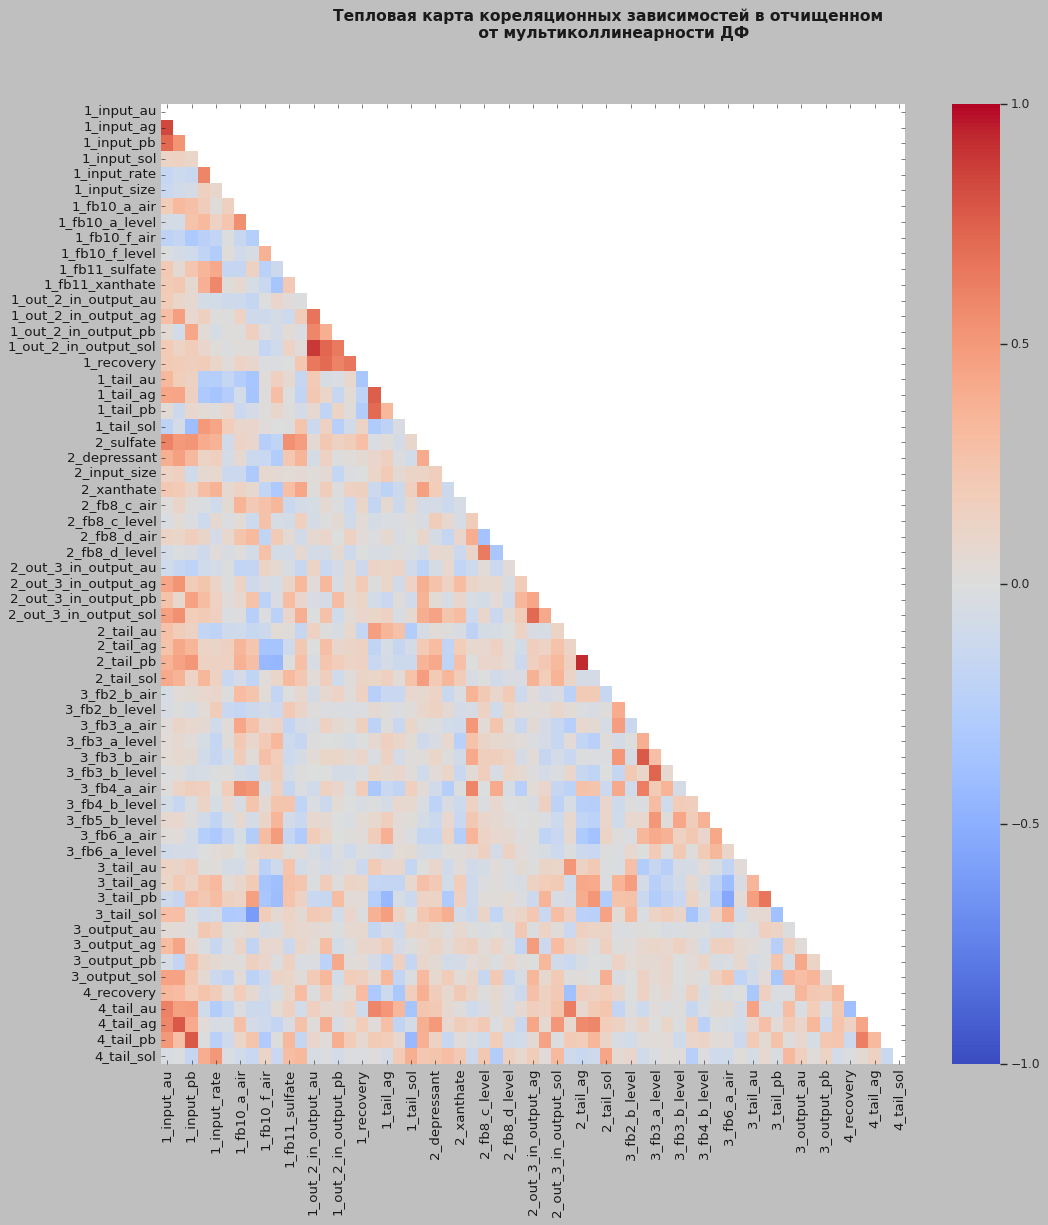

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 15))
# Заголовок фигуры
fig.suptitle\
('Тепловая карта кореляционных зависимостей в отчищенном \n от мультиколлинеарности ДФ', \
 fontsize=14, fontweight='bold');
#Тепловая карта корреляции (без удаленных столбцов)
upp_mat = np.triu(ddict['train']['data_no_corr'].corr())
sns.set(rc = {'figure.figsize':(15,15)})
sns.heatmap(ddict['train']['data_no_corr'].corr(),\
            vmin = -1, vmax = +1, annot = False, cmap = 'coolwarm', mask = upp_mat);

## Изучение состава признаков и таргетов

Для обучения модели определим состав основных Признаков и Таргетов.
1. Таргеты: качество обогащения ('1_recovery','4_recovery') 
2. Признаки: настройки системы для каждого из этапов и параметры входного для этапа флотации сырья

Следует отметить следующие важные моменты:
1. При обучении надо учесть, что параметры установок являются основным признаком и постараться снизить риск занижения их весов в моделях. Поскольку мы в конечном счете должны оценить именно то, как хорошо отчищается сырье, а не то, как много золота мы получим на выходе.
2. Для обучения стоит использовать только те признаки, которые есть в тестовом датафрейме. То есть для оценки реальных установок нам будут предоставлены только они.
3. ДЛя проверки качества предсказания ТАРГЕТЫ можно будет взять из полного ДФ 

### Тестовые признаки

In [ ]:
ddict['test']['data'].columns

Index(['date', '1_input_au', '1_input_ag', '1_input_pb', '1_input_sol',
       '1_input_rate', '1_input_size', '1_fb10_sulfate', '1_fb10_xanthate',
       '1_fb10_a_air', '1_fb10_a_level', '1_fb10_b_air', '1_fb10_b_level',
       '1_fb10_c_air', '1_fb10_c_level', '1_fb10_d_air', '1_fb10_d_level',
       '1_fb10_e_air', '1_fb10_e_level', '1_fb10_f_air', '1_fb10_f_level',
       '1_fb11_sulfate', '1_fb11_xanthate', '2_sulfate', '2_depressant',
       '2_input_size', '2_xanthate', '2_fb8_a_air', '2_fb8_a_level',
       '2_fb8_b_air', '2_fb8_b_level', '2_fb8_c_air', '2_fb8_c_level',
       '2_fb8_d_air', '2_fb8_d_level', '3_fb2_a_air', '3_fb2_a_level',
       '3_fb2_b_air', '3_fb2_b_level', '3_fb3_a_air', '3_fb3_a_level',
       '3_fb3_b_air', '3_fb3_b_level', '3_fb4_a_air', '3_fb4_a_level',
       '3_fb4_b_air', '3_fb4_b_level', '3_fb5_a_air', '3_fb5_a_level',
       '3_fb5_b_air', '3_fb5_b_level', '3_fb6_a_air', '3_fb6_a_level'],
      dtype='object')

Фактически тестовые признаки, по которым мы должны оценить качество работы установки это:
- настройки установок 1, 2, 3 (settings_cols_1, settings_cols_2, settings_cols_3)
- сведения о реагентах 1, 2, 3 этапов (reagent_cols_1, reagent_cols_2, reagent_cols_3)
- сведения о начальнойконцентрации МЕ в сырье 1 этапа (input_cols_1)   

### Разделение данных на ДФ для этапов обработки

In [ ]:
#Разделяем признаки на смысловые группы по этапам обработки
settings_cols_1 = ['1_fb10_sulfate', '1_fb10_xanthate','1_fb11_sulfate',\
                   '1_fb11_xanthate', '1_fb10_a_air', '1_fb10_a_level',\
                   '1_fb10_b_air', '1_fb10_b_level', '1_fb10_c_air', \
                   '1_fb10_c_level','1_fb10_d_air', '1_fb10_d_level', \
                   '1_fb10_e_air', '1_fb10_e_level','1_fb10_f_air', '1_fb10_f_level']

settings_cols_2 = ['2_sulfate', '2_depressant', '2_input_size', '2_xanthate',
                   '2_fb8_a_air', '2_fb8_a_level', '2_fb8_b_air', '2_fb8_b_level',
                   '2_fb8_c_air', '2_fb8_c_level', '2_fb8_d_air', '2_fb8_d_level']

settings_cols_3 = ['3_fb2_a_air', '3_fb2_a_level','3_fb2_b_air', '3_fb2_b_level', \
                   '3_fb3_a_air', '3_fb3_a_level','3_fb3_b_air', '3_fb3_b_level', \
                   '3_fb4_a_air', '3_fb4_a_level', '3_fb4_b_air', '3_fb4_b_level',\
                   '3_fb5_a_air', '3_fb5_a_level', '3_fb5_b_air', '3_fb5_b_level', \
                   '3_fb6_a_air', '3_fb6_a_level']

input_cols_1 = ['1_input_ag', '1_input_pb', '1_input_rate', '1_input_size',
                '1_input_sol', '1_input_au'] 

#Итоговый набор признаков для первой модели (с корреляцией)
first_settings_cols = copy.deepcopy(settings_cols_1)
first_settings_cols.extend(input_cols_1)

#Итоговый набор признаков для первой модели (без корреляции)
first_settings_cols_no_corr = copy.deepcopy(first_settings_cols)
for element in corr_columns:
    try:
        first_settings_cols_no_corr.remove(element)
    except:
        pass

#Итоговый набор признаков для первой модели (с корреляцией)
second_settings_cols = copy.deepcopy(first_settings_cols)
second_settings_cols.extend(settings_cols_2)
second_settings_cols.extend(settings_cols_3)

#Итоговый набор признаков для первой модели (без корреляции)
second_settings_cols_no_corr = copy.deepcopy(second_settings_cols)
for element in corr_columns:
    try:
        second_settings_cols_no_corr.remove(element)
    except:
        pass

## Проверка расчета эффективности обагощения

### Эффективность обагощения после флотации

In [ ]:
#Расчет эффективности обагощения после флотации на тренировочной выборке
for row_idx in ddict['train']['data'].index:
    ddict['train']['data'].loc[row_idx,'calc_recovery'] = \
    calc_recovery(ddict['train']['data'].loc[row_idx], \
                  '1_input_au', '1_out_2_in_output_au', '1_tail_au')    

In [ ]:
#Расчет MAE
MAE = mean_absolute_error(ddict['train']['data']['1_recovery'], ddict['train']['data']['calc_recovery'])
print(MAE)

1.1179874645656346e-14


### Эффективность обагощения финальная

In [ ]:
#Расчет эффективности обагощения после флотации на тренировочной выборке
for row_idx in ddict['train']['data'].index:
    ddict['train']['data'].loc[row_idx,'final_calc_recovery'] = \
    calc_recovery(ddict['train']['data'].loc[row_idx], \
                  '1_input_au', '3_output_au', '4_tail_au') 

In [ ]:
#Расчет MAE
MAE = mean_absolute_error(ddict['train']['data']['4_recovery'],\
                          ddict['train']['data']['final_calc_recovery'])
print(MAE)

9.631194310171483e-15


Рассчитанное значение среднего значения абсолютного отклонения стремиться к нулю, что означает, что расчетные и зафиксированные значения эффективности обогащеня практически полностью совпали. Отдельные расхождения объясняются наличием в ДФ искуственно "заполненных" пропусков.

## Исследование данных

### Исследование изменения концентрации элементов на каждом этапе

Для автоматизации отрисовки графиков и части расчетов создадим списки признаков, объединенные по типу металла и этапу обработки 

### Графики по концентрациям на различных этапах обработки

In [ ]:
#Золото
au_list = ['1_input_au', '1_out_2_in_output_au', '2_out_3_in_output_au', '3_output_au']
#Серебро
ag_list = ['1_input_ag', '1_out_2_in_output_ag', '2_out_3_in_output_ag', '3_output_ag']
#Свинец
pb_list = ['1_input_pb', '1_out_2_in_output_pb', '2_out_3_in_output_pb', '3_output_pb']
#Шлаки
sol_list = ['1_input_sol', '1_out_2_in_output_sol', '2_out_3_in_output_sol', '3_output_sol']

#Суммарный список
me_list = [au_list, ag_list, pb_list, sol_list]

#Подписи
labels = ['сырье', 'черновой концетрат','после первой отчистки', 'после второй отчистки']
step_labels = ['до флотации', 'после флотации','после первой отчистки', 'после второй отчистки']

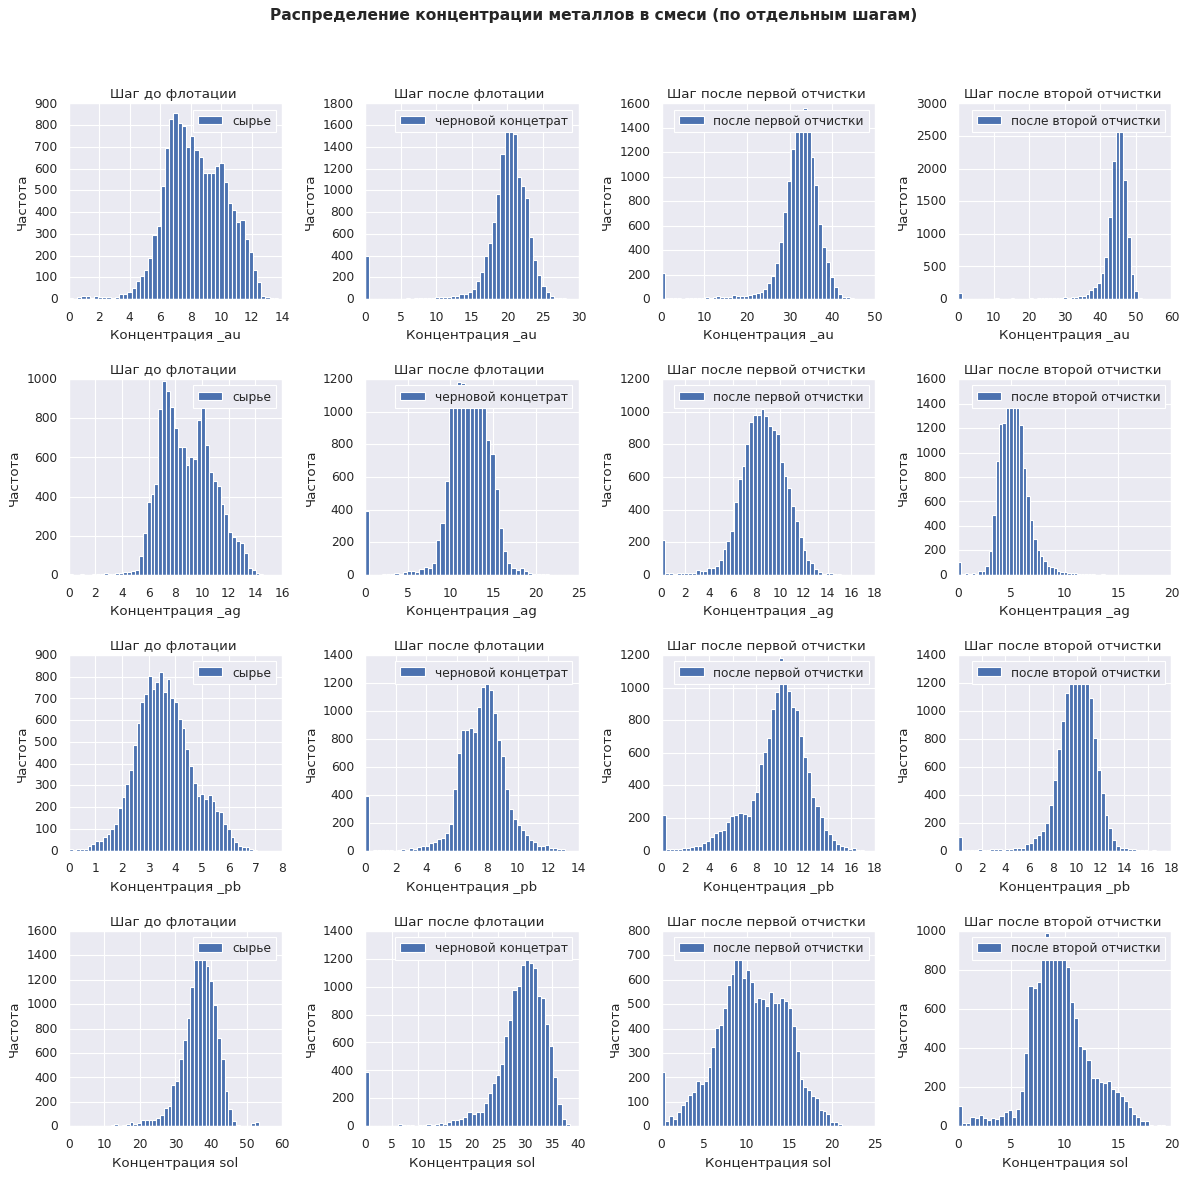

In [ ]:
#Распределение концентрации металлов в смеси по шагам для всех видов металла
fig, axes = plt.subplots(nrows = 4, ncols = 4, sharey = False, figsize = (15, 15))
# Заголовок фигуры
fig.suptitle('Распределение концентрации металлов в смеси (по отдельным шагам)', fontsize=14, fontweight='bold');
for idy, me in enumerate(me_list):
    for idx, consentrate in enumerate(me):
        ddict['train']['data']\
            .plot(kind = 'hist', y = consentrate, bins = 50, ax = axes[idy][idx], label = labels[idx])
        axes[idy][idx].set_xlabel(f'Концентрация {consentrate[-3:]}')
        axes[idy][idx].set_ylabel('Частота');
        axes[idy][idx].set(title = f"Шаг {step_labels[idx]} ")
        axes[idy][idx].legend().set_visible(True)

#Определяем расстояние между заголовками графиков
fig. tight_layout (h_pad= 2)
#Определяем отступ для основного заголовка
plt.subplots_adjust(top= 0.90) 

Выводы по изменению концентраций:
Анализируя графики можно отметить следующее:
1. Золото
    1.1. Медиана плотности вероятности распределения концентрации золота в результирующем продукте (выход) в процессе обагощения от первого этапа до финального постепенно сдвигается от 20 до 45 %. При этом среднее квадратическое отклонение уменьшается, то есть график становиться более компактным и основная масса значений финальной концентрации сосредотачивается в диапазоне от 40 до 50 %.  

2. Серебро
    2.1. Медиана плотности вероятности распределения концентрации серебра в результирующем продукте (выход) в процессе обагощения от первого этапа до финального постепенно сдвигается от 12 до 5 %. При этом среднее квадратическое отклонение уменьшается, то есть график становиться более компактным и основная масса значений финальной концентрации сосредотачивается в диапазоне от 2 до 10 %.  

3. Свинец
    3.1. Медиана плотности вероятности распределения концентрации свинца в результирующем продукте (выход) в процессе обагощения от первого этапа до финального незначительно сдвигается от 1 до 6 %. При этом среднее квадратическое отклонение сильно увеличивается, то есть график становиться более размазанным и основная масса значений финальной концентрации сосредотачивается в диапазоне от 10 до 20 %.
  
4. Шлак
    4.1. Медиана плотности вероятности распределения концентрации шлака в результирующем продукте (выход) в процессе обагощения от первого этапа до финального сдвигается от 35 до 10 %. При этом среднее квадратическое отклонение незначительно увеличивается, основная масса значений финальной концентрации сосредотачивается в диапазоне от 5 до 20 %.  

### Графики по концентрациям по отдельным шагам объединенный по всем составляющим смеси

---



In [ ]:
#Золото 1-3 этапы
au_list_1 = ['1_input_au', '1_out_2_in_output_au', '1_tail_au']
au_list_2 = ['1_out_2_in_output_au', '2_out_3_in_output_au', '2_tail_au']
au_list_3 = ['2_out_3_in_output_au', '3_output_au', '3_tail_au']
#Серебро 1-3 этапы
ag_list_1 = ['1_input_ag', '1_out_2_in_output_ag', '1_tail_ag']
ag_list_2 = ['1_out_2_in_output_ag', '2_out_3_in_output_ag', '2_tail_ag']
ag_list_3 = ['2_out_3_in_output_ag', '3_output_ag', '3_tail_ag']
#Свинец 1-3 этапы
pb_list_1 = ['1_input_pb', '1_out_2_in_output_pb', '1_tail_pb']
pb_list_2 = ['1_out_2_in_output_pb', '2_out_3_in_output_pb', '2_tail_pb']
pb_list_3 = ['2_out_3_in_output_pb', '3_output_pb', '3_tail_pb']
#Шлак 1-3 этапы
sol_list_1 = ['1_input_sol', '1_out_2_in_output_sol', '1_tail_sol']
sol_list_2 = ['1_out_2_in_output_sol', '2_out_3_in_output_sol', '2_tail_sol']
sol_list_3 = ['2_out_3_in_output_sol', '3_output_sol', '3_tail_sol']
#Списки, сгруппированные по металлам
au_list = [au_list_1, au_list_2, au_list_3]
ag_list = [ag_list_1, ag_list_2, ag_list_3]
pb_list = [pb_list_1, pb_list_2, pb_list_3]
sol_list = [sol_list_1, sol_list_2, sol_list_3]
#Все металлы
metal_lists = [au_list, ag_list, pb_list, sol_list]
#Общий список без подсписокв
all_list = list(itertools.chain.from_iterable(list(itertools.chain.from_iterable(metal_lists))))


In [ ]:
#Дифференциация стадий обработки по этапам (входное, выходное сырье, хвосты)
step_1 = ['date', '1_input_au', '1_out_2_in_output_au', '1_tail_au', 
           '1_input_ag', '1_out_2_in_output_ag', '1_tail_ag', 
           '1_input_pb', '1_out_2_in_output_pb', '1_tail_pb',
           '1_input_sol', '1_out_2_in_output_sol', '1_tail_sol']

step_2 = ['date','1_out_2_in_output_au', '2_out_3_in_output_au', '2_tail_au',
           '1_out_2_in_output_ag', '2_out_3_in_output_ag', '2_tail_ag',
          '1_out_2_in_output_pb', '2_out_3_in_output_pb', '2_tail_pb',
           '1_out_2_in_output_sol', '2_out_3_in_output_sol', '2_tail_sol']

step_3 = ['date','2_out_3_in_output_au', '3_output_au', '3_tail_au',
           '2_out_3_in_output_ag', '3_output_ag', '3_tail_ag',
           '2_out_3_in_output_pb', '3_output_pb', '3_tail_pb',
           '2_out_3_in_output_sol', '3_output_sol', '3_tail_sol']

step_4 = ['date', '4_tail_pb', '4_tail_sol', '4_tail_au', '4_tail_ag']

steps = {
'step_1': step_1,
'step_2': step_2,
'step_3': step_3,
'step_4': step_4,}

#### Вспомогательных ДФ для графиков концентраций

In [ ]:
#Вспомогательный ДФ с возможностью группировки по этапам  
pieces = {"step_1": ddict['train']['data'][step_1],\
          "step_2": ddict['train']['data'][step_2],\
          "step_3": ddict['train']['data'][step_3],
          "step_4": ddict['train']['data'][step_4],}

data_con = pd.concat(pieces)
data_con = data_con.reset_index( level = [0])

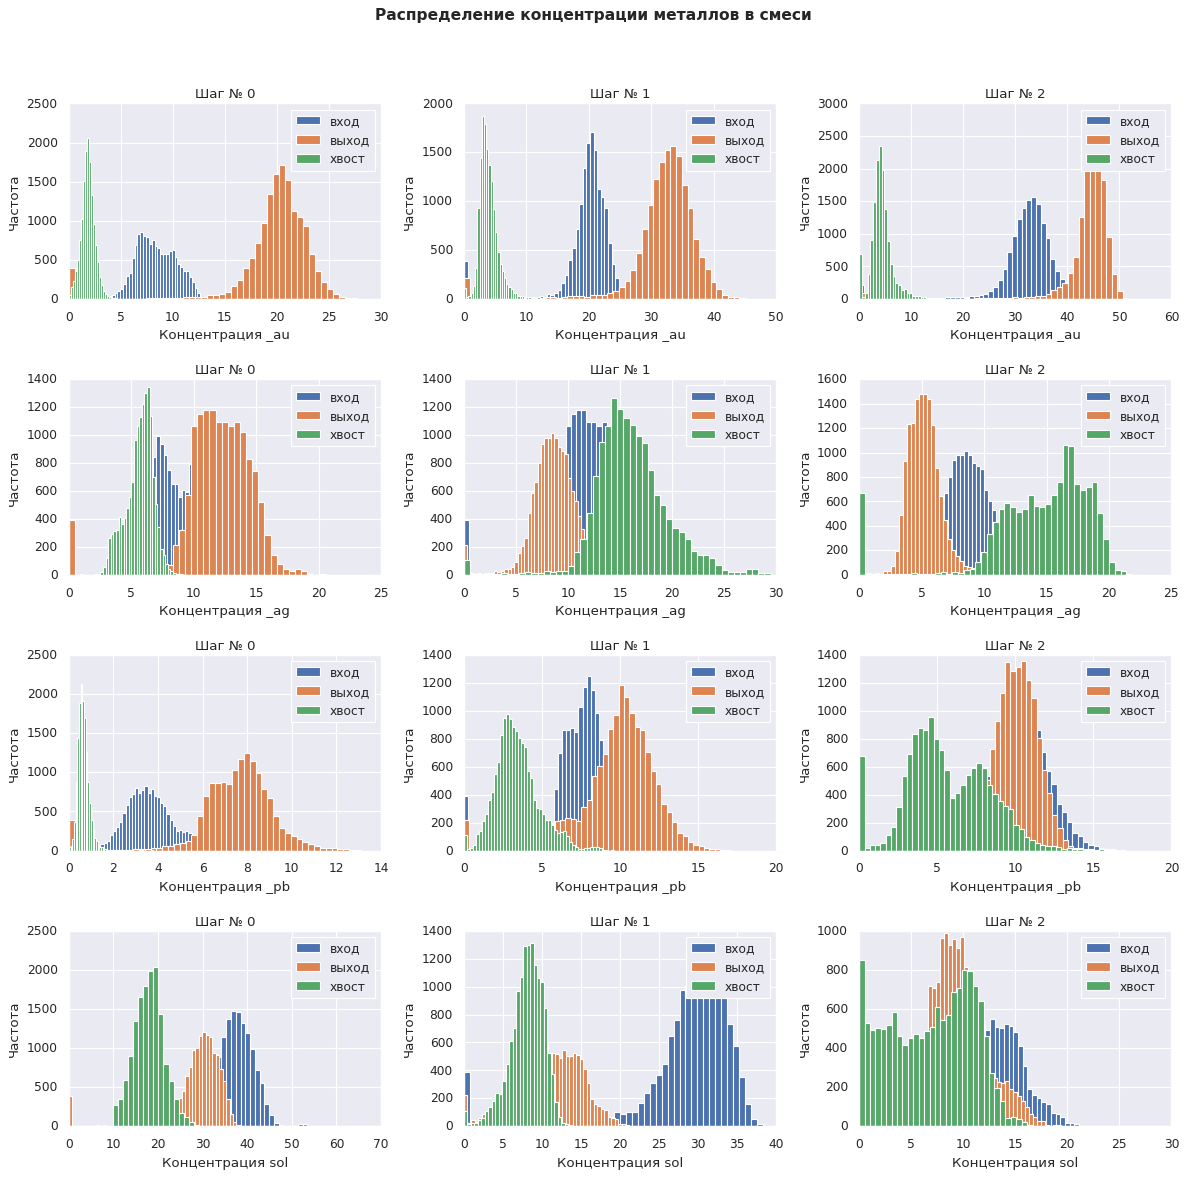

In [ ]:
#Функция для плотностей вероятности по шагам для всех смесей
fig, axes = plt.subplots(nrows = 4, ncols = 3, sharey = False, figsize = (15, 15))
# Заголовок фигуры
fig.suptitle('Распределение концентрации металлов в смеси', fontsize=14, fontweight='bold');
for idy, me_list in enumerate(metal_lists):
    for idx, step in enumerate(steps):
        if step != 'step_4':
            data_con.query('level_0 == @step')\
            .plot(kind = 'hist', y = me_list[idx][0], bins = 50, ax = axes[idy][idx], label = 'вход')
            data_con.query('level_0 == @step')\
                .plot(kind = 'hist', y = me_list[idx][1], bins = 50, ax = axes[idy][idx], label = 'выход')
            data_con.query('level_0 == @step')\
                .plot(kind = 'hist', y = me_list[idx][2], bins = 50, ax = axes[idy][idx], label = 'хвост')
            axes[idy][idx].set_xlabel(f'Концентрация {me_list[idx][0][-3:]}')
            axes[idy][idx].set_ylabel('Частота');
            axes[idy][idx].set(title = f"Шаг № {idx}")
            axes[idy][idx].legend().set_visible(True)

#Определяем расстояние между заголовками графиков
fig. tight_layout (h_pad= 2)
#Определяем отступ для основного заголовка
plt.subplots_adjust(top= 0.90) 

Анализируя графики можно отметить следующее:
1. Золото
    1.1. Медиана плотности вероятности распределения концентрации золота в результирующем продукте (выход) в процессе обагощения от первого этапа до финального постепенно сдвигается от 20 до 45 %. При этом среднее квадратическое отклонение уменьшается, то есть график становиться более компактным и основная масса значений финальной концентрации сосредотачивается в диапазоне от 40 до 50 %.  

    1.2. Медиана плотности вероятности распределения концентрации золота в хвостах в процессе обагощения от первого этапа до финального почти не меняется. Это логично. В хвосты в идеальном случае недолны попадать драгоценные металлы никогда.
    
    1.3. Медиана плотности вероятности распределения концентрации золота во входном продукте (вход) ведет себя аналогично выходному продукту. При этом начальная полодительная ассиметрия в процессе обагощения преобразуется в отрицательную. 

2. Серебро
    2.1. Медиана плотности вероятности распределения концентрации серебра в результирующем продукте (выход) в процессе обагощения от первого этапа до финального постепенно сдвигается от 12 до 5 %. При этом среднее квадратическое отклонение уменьшается, то есть график становиться более компактным и основная масса значений финальной концентрации сосредотачивается в диапазоне от 2 до 10 %.  

    2.2. Медиана плотности вероятности распределения концентрации серебра в хвостах в процессе обагощения от первого этапа до финального постепенно сдвигается от 6 до 15 %. При этом среднее квадратическое отклонение увеличивается, то есть график становиться более размазанным и основная масса значений финальной концентрации сосредотачивается в диапазоне от 10 до 20 %.

    2.3. Медиана плотности вероятности распределения концентрации серебра во входном продукте (вход) ведет себя аналогично выходному продукту. 
    
3. Свинец
    3.1. Медиана плотности вероятности распределения концентрации свинца в результирующем продукте (выход) в процессе обагощения от первого этапа до финального незначительно сдвигается от 1 до 6 %. При этом среднее квадратическое отклонение сильно увеличивается, то есть график становиться более размазанным и основная масса значений финальной концентрации сосредотачивается в диапазоне от 10 до 20 %.
    3.2. Медиана плотности вероятности распределения концентрации свинца в хвостах в процессе обагощения от первого этапа до финального постепенно сдвигается от 6 до 15 %. При этом среднее квадратическое отклонение увеличивается, то есть график становиться более размазанным и основная масса значений финальной концентрации сосредотачивается в диапазоне от 2 до 12 %.

3. Шлак
    3.1. Медиана плотности вероятности распределения концентрации шлака в результирующем продукте (выход) в процессе обагощения от первого этапа до финального сдвигается от 30 до 9 %. При этом среднее квадратическое отклонение незначительно увеличивается, основная масса значений финальной концентрации сосредотачивается в диапазоне от 5 до 20 %.
    3.2. Медиана плотности вероятности распределения концентрации шкака в хвостах в процессе обагощения от первого этапа до финального постепенно сдвигается от 18 до 8 %. При этом среднее квадратическое отклонение значительно увеличивается, то есть график становиться более размазанным и основная масса значений финальной концентрации сосредотачивается в диапазоне от 0 до 15 %.
    
    ВЫВОДЫ:
    1. Концентрация золота показывает ожидаемую тенденцию к увеличению в итоговом продукте и относительно стабильную низкую величину в хвостах.
    2. Концентрация серебра показывает ожидаемую тенденцию к уменьшению в итоговом продукте и небольшому увеличению в хвостах.
    3. Концентрация свинца показывает неожиданную тенденцию к увеличению в итоговом продукте (видимо за счет уменьшения концентрации другого МУСОРА, данных по которому у нас нет) и ожидаемое увеличение в хвостах.
    4. Концентрация шлака показывает ожидаемую тенденцию к уменьшению в итоговом продукте и неожидаенное уменьшение в хвостах (за счет значительного увеличение вхвостахконцентрации другого МУСОРА).

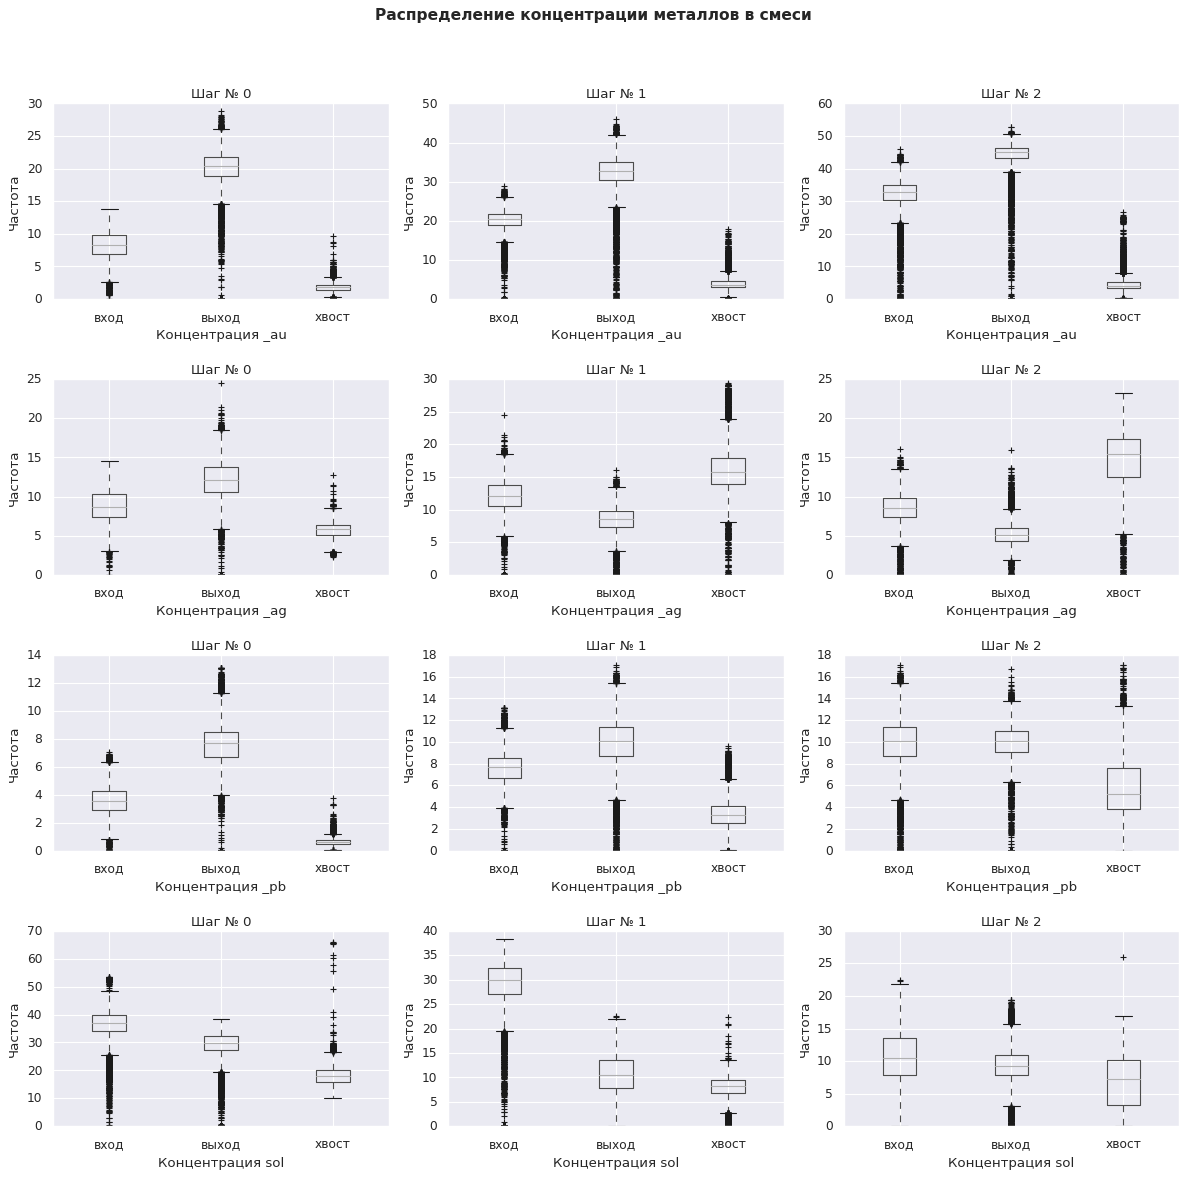

In [ ]:
#Функция для диаграмм размаха по шагам для всех видов металла
fig, axes = plt.subplots(nrows = 4, ncols = 3, sharey = False, figsize = (15, 15))
# Заголовок фигуры
fig.suptitle('Распределение концентрации металлов в смеси', fontsize=14, fontweight='bold');
for idy, me_list in enumerate(metal_lists):
    for idx, step in enumerate(steps):
        if step != 'step_4':
            data_con.query('level_0 == @step').boxplot(column = me_list[idx], vert=True, ax = axes[idy][idx])
            axes[idy][idx].set_xlabel(f'Концентрация {me_list[idx][0][-3:]}')
            axes[idy][idx].set_ylabel('Частота');
            axes[idy][idx].set(title = f"Шаг № {idx}")
            axes[idy][idx].set_xticklabels(['вход', 'выход','хвост'])
            

#Определяем расстояние между заголовками графиков
fig. tight_layout (h_pad= 2)
#Определяем отступ для основного заголовка
plt.subplots_adjust(top= 0.90)


### Сводная таблица по средним концентрациям

In [ ]:
pd.pivot_table(data_con, values = all_list, index = 'level_0', columns=None, aggfunc='median');

<ipython-input-204-5444f92b3173>:1: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  pd.pivot_table(data_con, values = all_list, index = 'level_0', columns=None, aggfunc='median');


## Исследование суммарных концентраций

### Расчет суммарных концентраций

In [ ]:
data_con = calc_sum_density(data_con)

### Плотности распределения вероятностей суммарных концентраций

### Гистограммы суммарных концентраций

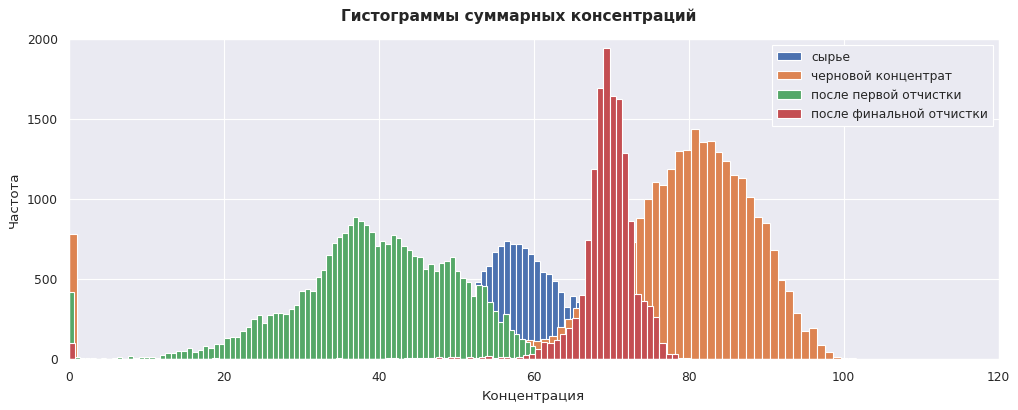

In [ ]:
list_of_alls = ['input_all', 'rough_output', 'first_clean_output', 'output_all']
labels = ['сырье', 'черновой концентрат','после первой отчистки','после финальной отчистки']
#Гистограммы для суммарных концентраций
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
# Заголовок фигуры
fig.suptitle('Гистограммы суммарных консентраций', fontsize=14, fontweight='bold');
for idx, type_feed in enumerate(list_of_alls):
    data_con.plot(kind = 'hist', y = type_feed, bins = 100, ax = axes, label = labels[idx])
    axes.set_xlabel(f'Концентрация')
    axes.set_ylabel('Частота');

На графиках наблюдается очень любопытная картина:
1. Самая большая суммарная концентрация наблюдается в черновом концентрате (после флотации). Видимо за счет того, что на этом этапе отсеивается основной МУСОР 
2. После первой отчистики суммарная концентрация резко снижается до значений, даже меньших концентрации в сырье (видимо за счет того, что из смеси начинают выкидывать шлак и другие металлы)
3. После второй отчистки концентрация увеличивается, но все же остается ниже концентрации чернового концентрата (видимо из смеси снова удаляется МУСОР)


### Диаграмма размаха суммарных концентраций

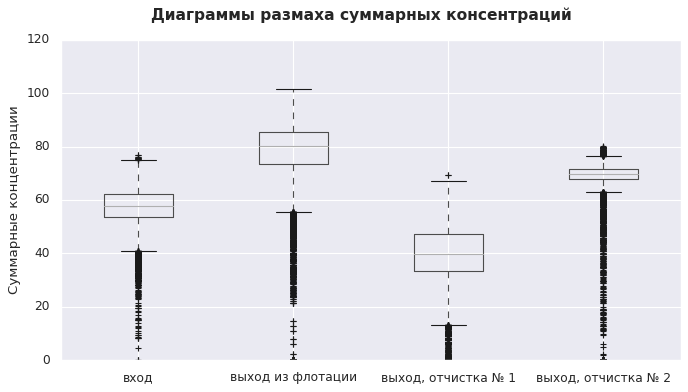

In [ ]:
#Функция для диаграмм размаха по шагам для суммарных концентраций
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (10, 5))
# Заголовок фигуры
fig.suptitle('Диаграммы размаха суммарных консентраций', fontsize=14, fontweight='bold');
data_con.boxplot(column = list_of_alls, vert=True, ax = axes);
axes.set_ylabel(f'Суммарные концентрации')
axes.set_xticklabels(['вход', 'выход из флотации','выход, отчистка № 1', 'выход, отчистка № 2']);

Проверим, есть ли концентрации, равные 0, для чего изменим пределы графиков

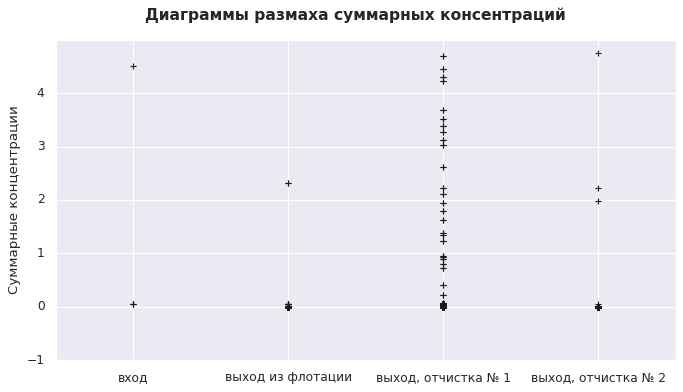

In [ ]:
#Функция для диаграмм размаха по шагам для суммарных концентраций
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (10, 5))
# Заголовок фигуры
fig.suptitle('Диаграммы размаха суммарных консентраций', fontsize=14, fontweight='bold');
data_con.boxplot(column = list_of_alls, \
                 vert=True, ax = axes);
axes.set(ylim=(-1, 5), yticks=np.arange(-1, 5));
axes.set_ylabel(f'Суммарные концентрации')
axes.set_xticklabels(['вход', 'выход из флотации','выход, отчистка № 1', 'выход, отчистка № 2']);

По гистограммах и диаграммам размаха видно,что в ДФ есть записи,в которых суммарные концентрации равны 0. Такие записи наиболее вероятно являются ошибочными:
- во-первых если все концентрации нулевые, то такое сырье не имеет смысла обрабатывать
- во-вторых при расчете эффективности с такими данными мы получим ошибку деления на ноль. Удалим из ДФ записи с нулевыми суммарными концентрациями
- в-третьих согласно техническому заданию данные получались в режиме, близком к реальному, в разное время, соответственно, выявленные нулевые значения могут быть связаны с тем, что на момент сбора информации данные о концентрациях веществ на выходе с этапа обработки еще отсутствовали. 

Посчитаем долю таких нулевых(ошибочных) значений для каждого их этапов 

In [ ]:
print(f'''В ДФ выявлены нулевые значения суммарных концентраций в количестве:
1. Для этапа флотации - {len(data_con.query('level_0 == "step_1" and (output_all < 0.01 or input_all < 0.01)'))},
2. Для этапа первичной отчистки - {len(data_con.query('level_0 == "step_2" and (output_all < 0.01 or input_all < 0.01)'))},
3. Для этапа вторичной отчистки - {len(data_con.query('level_0 == "step_3" and (output_all < 0.01 or input_all < 0.01)'))}''')

В ДФ выявлены нулевые значения суммарных концентраций в количестве:
1. Для этапа флотации - 0,
2. Для этапа первичной отчистки - 0,
3. Для этапа вторичной отчистки - 98


Так как нулевые значения не "реальны", то есть ошибочны, они могут снизить качество обучения модели. Так как их суммарно не много, их представляется возможным удалить. 

### Удаление записей с нулевыми (близкими к нулевым) суммарным концентрациям

In [ ]:
#Определяем список значений дат, в которые выявлены ошибочные концентрации
list_of_date = list(data_con\
                    .query('(output_all < 0.1) or (rough_output < 0.1) or \
                            (first_clean_output < 0.1) or (input_all < 0.1)').date)

In [ ]:
#Удаляем строки из всех ДФ (с и без корреляции)
for item in ddict.values():
    item['data'] = item['data'].query('date not in @list_of_date')
    item['data_no_corr'] = item['data_no_corr'].query('date not in @list_of_date')

### Контроль удаления записей с нулевыми (близкими к нулевым) суммарным концентрациям

In [ ]:
#Пересчет всомогательного ДФ
pieces = {"step_1": ddict['train']['data'][step_1],\
          "step_2": ddict['train']['data'][step_2],\
          "step_3": ddict['train']['data'][step_3],
          "step_4": ddict['train']['data'][step_4],}

data_con = pd.concat(pieces)
data_con = data_con.reset_index( level = [0])

#Пересчет суиммарных концентраций
data_con = calc_sum_density(data_con)

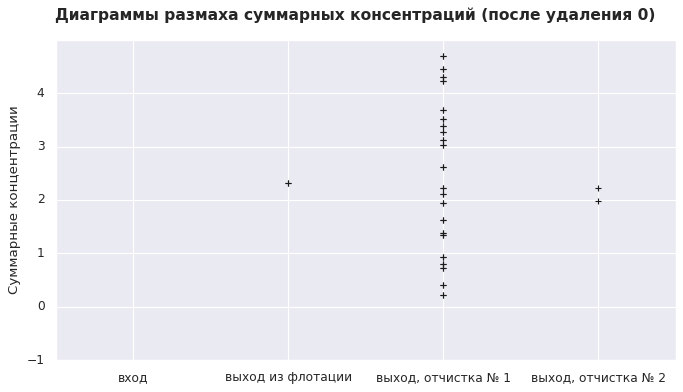

In [ ]:
#Диаграмма размаха по шагам для суммарных концентраций
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (10, 5))
# Заголовок фигуры
fig.suptitle('Диаграммы размаха суммарных консентраций (после удаления 0)', fontsize=14, fontweight='bold');
data_con.boxplot(column = list_of_alls, \
                 vert=True, ax = axes);
axes.set(ylim=(-1, 5), yticks=np.arange(-1, 5));
axes.set_ylabel(f'Суммарные концентрации')
axes.set_xticklabels(['вход', 'выход из флотации','выход, отчистка № 1', 'выход, отчистка № 2']);

## Сравнение распределений размеров гранул на обучающей и тестовой выборках

In [ ]:
#Размеры гранул
test_size = ddict['test']['data']['1_input_size']
train_size = ddict['train']['data']['1_input_size']
train_size_2 = ddict['train']['data']['2_input_size']

In [ ]:
# Формируем ДФ с данными о размере гранул
size_df = pd.merge(ddict['full']['data'], ddict['test']['data'], on = 'date')

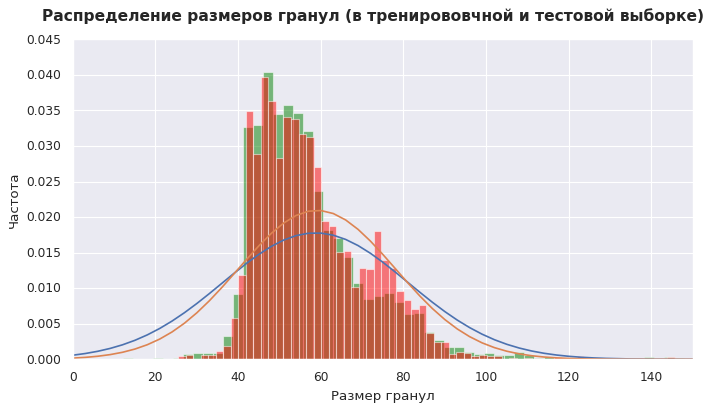

In [ ]:
#Распределение размера гранул
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (10, 5))
# Заголовок фигуры
fig.suptitle('Распределение размеров гранул (в тренирововчной и тестовой выборке)', fontsize=14, fontweight='bold');
axes.set_xlabel(f'Размер гранул')
axes.set_ylabel('Частота')

train_size.plot(kind = 'hist', y = '1_input_size', \
                bins = 200, ax = axes, stacked = True, density = True,\
                color = 'green', alpha = 0.5, xlim = (0, 150))

test_size.plot(kind = 'hist', y = '1_input_size',\
               bins = 200, ax = axes, stacked = True, density = True,
               color = 'red', alpha = 0.5)

#Параметры нормального распределения для train
train_std = np.std(train_size)
train_mu = np.mean(train_size)
train_std_2 = np.std(train_size_2)
train_mu_2 = np.mean(train_size_2)

#Параметры нормального распределения для test
test_std = np.std(test_size)
test_mu = np.mean(test_size)

#Нормальное распределение с параметрами распределения прибыли
train_x = np.arange (min(train_size), max(train_size), 3)
train_x_2 = np.arange (min(train_size_2), max(train_size_2), 3)
test_x = np.arange (min(test_size), max(test_size), 3)

#Графики нормального распределения
axes.plot(train_x, norm.pdf(train_x, train_mu, train_std))
axes.plot(test_x, norm.pdf(test_x, test_mu, test_std));
axes.set_ylabel('Частота');

В целом распределения находятся в одном диапазоне за исключением выбросов, размещенных левее 20 и правее  120. Удалим эти выбросы.

In [ ]:
#Удаление выбросов
train_size = ddict['train']['data'][\
                                   ((ddict['train']['data']['1_input_size'] > 20) & \
                                   (ddict['train']['data']['1_input_size'] < 120))]['1_input_size']

test_size = ddict['test']['data'][\
                                   ((ddict['test']['data']['1_input_size'] > 20) & \
                                   (ddict['test']['data']['1_input_size'] < 120))]['1_input_size']

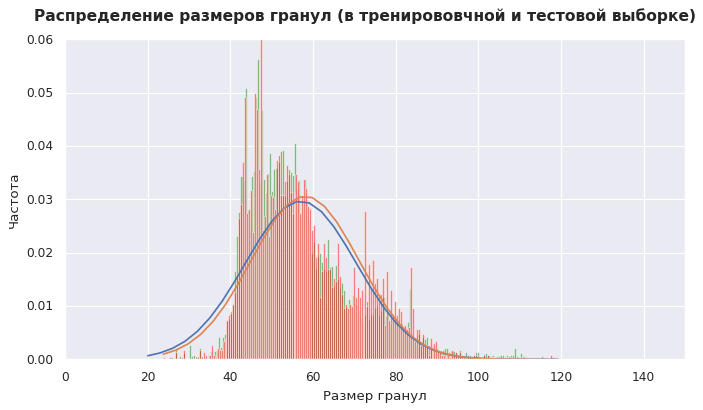

In [ ]:
#Распределение размера гранул
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (10, 5))
# Заголовок фигуры
fig.suptitle('Распределение размеров гранул (в тренирововчной и тестовой выборке)', fontsize=14, fontweight='bold');
axes.set_xlabel(f'Размер гранул')
axes.set_ylabel('Частота')

train_size.plot(kind = 'hist', y = '1_input_size', \
                bins = 200, ax = axes, stacked = True, density = True,\
                color = 'green', alpha = 0.5, xlim = (0, 150))

test_size.plot(kind = 'hist', y = '1_input_size',\
               bins = 200, ax = axes, stacked = True, density = True,
               color = 'red', alpha = 0.5)

#Параметры нормального распределения для train
train_std = np.std(train_size)
train_mu = np.mean(train_size)
train_std_2 = np.std(train_size_2)
train_mu_2 = np.mean(train_size_2)

#Параметры нормального распределения для test
test_std = np.std(test_size)
test_mu = np.mean(test_size)

#Нормальное распределение с параметрами распределения прибыли
train_x = np.arange (min(train_size), max(train_size), 3)
train_x_2 = np.arange (min(train_size_2), max(train_size_2), 3)
test_x = np.arange (min(test_size), max(test_size), 3)

#Графики нормального распределения
axes.plot(train_x, norm.pdf(train_x, train_mu, train_std))
axes.plot(test_x, norm.pdf(test_x, test_mu, test_std));
axes.set_ylabel('Частота');

Судя по построенным гистогаммам, значения размеров гранул находяться и в тестовой и в тренировочной выборках распределены в диапазоне от20 до 120 условных единиц. Вместе с тем распределения значений этих величин имеют разную, далекую от нормальной форму. Однако, построенные по рассчитанным для них медиане и СТД нормальные распределения в целом достаточно близки друг к другу. С учетом изложенного можно предположить, что расхождения в распределениях не должны сильно исказить предсказания машинных моделей. 

Проверим как соотносятся друг с другом распределения размеров гранул на входе и выходе с режима флотации

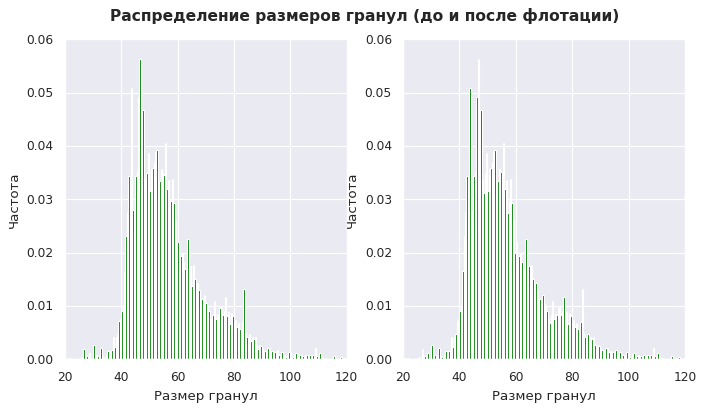

In [ ]:
#Распределение размера гранул
fig, axes = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize = (10, 5))
# Заголовок фигуры
fig.suptitle('Распределение размеров гранул (до и после флотации)', fontsize=14, fontweight='bold');
for idx, col in enumerate(['1_input_size', '2_input_size']):
    axes[idx].set_xlabel(f'Размер гранул')
    train_size.plot(kind = 'hist', y = col, \
                bins = 200, stacked = True, density = True,\
                color = 'green', alpha = 1, ax = axes[idx])
axes[0].set_ylabel('Частота')
axes[1].set_ylabel('Частота');

Распределение размера гранул до и после флатации полностью идентично

## Подготовка машинного обучения

### Признаки для териноровочной выборки

#### Признаки для предсказания 1_recovery после флотации

In [ ]:
#Фичерсы и таргеты для первой модели (с корреляцией)
ddict['train']['first_target'] = ddict['train']['data']['1_recovery']
ddict['train']['first_features'] = ddict['train']['data'][first_settings_cols]

#Фичерсы и таргеты для первой модели (без корреляции)
ddict['train']['first_target_no_corr'] = ddict['train']['data_no_corr']['1_recovery']
ddict['train']['first_features_no_corr'] = ddict['train']['data_no_corr'][first_settings_cols_no_corr]

#### Признаки для предсказания 4_recovery после финальной обработки

In [ ]:
#Фичерсы и таргеты для второй модели (с корреляцией)
ddict['train']['second_target'] = ddict['train']['data']['4_recovery']
ddict['train']['second_features'] = ddict['train']['data'][second_settings_cols]

#Фичерсы и таргеты для первой модели (без корреляции)
ddict['train']['second_target_no_corr'] = ddict['train']['data_no_corr']['4_recovery']
ddict['train']['second_features_no_corr'] = ddict['train']['data_no_corr'][second_settings_cols_no_corr]

### Признаки для тестовой выборки

In [ ]:
dop_columns = ['1_recovery', '4_recovery', 'date']
#Добавляем в тестовый ДФ недостающие столбцы из полного ДФ
test_df = pd.merge(ddict['test']['data'], \
                   ddict['full']['data'][dop_columns], on='date', how = 'left')

test_df_no_corr = pd.merge(ddict['test']['data'], \
                   ddict['full']['data'][dop_columns], on='date', how = 'left')

#### Признаки для предсказания 1_recovery после флотации

In [ ]:
#Фичерсы и таргеты для первой модели (с корреляцией)
ddict['test']['first_target'] = test_df['1_recovery']
ddict['test']['first_features'] = test_df[first_settings_cols]

#Фичерсы и таргеты для первой модели (без корреляции)
ddict['test']['first_target_no_corr'] = test_df_no_corr['1_recovery']
ddict['test']['first_features_no_corr'] = test_df_no_corr[first_settings_cols_no_corr]

#### Признаки для предсказания 4_recovery после финальной обработки

In [ ]:
#Фичерсы и таргеты для первой модели (с корреляцией)
ddict['test']['second_target'] = test_df['4_recovery']
ddict['test']['second_features'] = test_df[second_settings_cols]

#Фичерсы и таргеты для первой модели (без корреляции)
ddict['test']['second_target_no_corr'] = test_df_no_corr['4_recovery']
ddict['test']['second_features_no_corr'] = test_df_no_corr[second_settings_cols_no_corr]

## Обработка фичерсов и таргетов

### Стандартизация тренировочной выборки

In [ ]:
# Коррелированые данные первой модели
first_scaller = StandardScaler()
first_scaller.fit(ddict['train']['first_features'])
ddict['train']['SS_first_features'] = first_scaller.transform(ddict['train']['first_features'])

# Коррелированые данные второй модели
second_scaller = StandardScaler()
second_scaller.fit(ddict['train']['second_features'])
ddict['train']['SS_second_features'] = second_scaller.transform(ddict['train']['second_features'])

# Не коррелированые данные первой модели
first_scaller_no_corr = StandardScaler()
first_scaller_no_corr.fit(ddict['train']['first_features_no_corr'])
ddict['train']['SS_first_features_no_corr'] = \
first_scaller_no_corr.transform(ddict['train']['first_features_no_corr'])

# Не коррелированые данные второй модели
second_scaller_no_corr = StandardScaler()
second_scaller_no_corr.fit(ddict['train']['second_features_no_corr'])
ddict['train']['SS_second_features_no_corr'] = \
second_scaller_no_corr.transform(ddict['train']['second_features_no_corr'])

### Стандартизация тестовой выборки

In [ ]:
# Коррелированые данные первой модели
ddict['test']['SS_first_features'] = first_scaller.transform(ddict['test']['first_features'])

# Коррелированые данные второй модели
ddict['test']['SS_second_features'] = second_scaller.transform(ddict['test']['second_features'])

# Некоррелированые данные первой модели
ddict['test']['SS_first_features_no_corr'] = first_scaller.transform(ddict['test']['first_features'])

# Некоррелированые данные второй модели
ddict['test']['SS_second_features_no_co'] = second_scaller.transform(ddict['test']['second_features']);

## Обучение объекта для оценки качетсва модели

In [ ]:
my_scorer = make_scorer(calc_sMAPE, greater_is_better = False)

## Обучение и тестирование моделей методом кроссвалидации (ПЕРВАЯ модель)

### Модель регрессии Lasso

#### Без стандартизации с корреляцией

In [ ]:
#Поиск лучшей модели типа Lasso (без стандартизации)
(model_L, params_L) = find_best_model(Lasso, 
                        ddict['train']['first_features'], ddict['train']['first_target'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'alpha': list(range(1, 5)),\
                            'tol': [0.00001, 0.0001],\
                            'splitter': ['best', 'random'],\
                            'max_iter': [1000, 2000]});

  0%|          | 0/32 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s finished
  3%|▎         | 1/32 [00:04<02:06,  4.08s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0694s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
  6%|▋         | 2/32 [00:04<00:54,  1.82s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0774s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
  9%|▉         | 3/3

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._coordinate_descent.Lasso'> показала эффективность (sMAPE):
     - на тренировочной выборке 8.070567940567393 с параметрами {'random_state': 1945, 'alpha': 1, 'tol': 0.0001, 'splitter': 'best', 'max_iter': 1000} 


#### Cо стандартизацией с корреляцией

In [ ]:
#Поиск лучшей модели типа Lasso (со стандартизацией)
(model_Ls, params_Ls) = find_best_model(Lasso, 
                        ddict['train']['SS_first_features'], ddict['train']['first_target'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'alpha': list(range(1, 5)),\
                            'tol': [0.00001, 0.0001],\
                            'splitter': ['best', 'random'],\
                            'max_iter': [1000, 2000]});

  0%|          | 0/32 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0663s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
  3%|▎         | 1/32 [00:00<00:05,  5.36it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0283s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
  6%|▋         | 2/32 [00:00<00:05,  5.94it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0274s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Paralle

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._coordinate_descent.Lasso'> показала эффективность (sMAPE):
     - на тренировочной выборке 7.027103399485761 с параметрами {'random_state': 1945, 'alpha': 1, 'tol': 0.0001, 'splitter': 'best', 'max_iter': 1000} 


#### Без стандартизации без корреляции

In [ ]:
#Поиск лучшей модели типа Lasso 
(model_Lnc, params_Lnc) = find_best_model(Lasso, 
                        ddict['train']['first_features_no_corr'], ddict['train']['first_target_no_corr'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'alpha': list(range(1, 5)),\
                            'tol': [0.00001, 0.0001],\
                            'splitter': ['best', 'random'],\
                            'max_iter': [1000, 2000]});

  0%|          | 0/32 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0546s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
  3%|▎         | 1/32 [00:00<00:05,  5.57it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0459s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
  6%|▋         | 2/32 [00:00<00:05,  5.63it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0434s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Paralle

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._coordinate_descent.Lasso'> показала эффективность (sMAPE):
     - на тренировочной выборке 7.6456939873258065 с параметрами {'random_state': 1945, 'alpha': 1, 'tol': 1e-05, 'splitter': 'random', 'max_iter': 1000} 


#### Со стандартизацией без корреляции

In [ ]:
#Поиск лучшей модели типа Lasso (со стандартизацией)
(model_Lsnc, params_Lsnc) = find_best_model(Lasso, 
                        ddict['train']['SS_first_features_no_corr'], ddict['train']['first_target_no_corr'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'alpha': list(range(1, 5)),\
                            'tol': [0.00001, 0.0001],\
                            'splitter': ['best', 'random'],\
                            'max_iter': [1000, 2000]});

  0%|          | 0/32 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0320s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0263s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
  6%|▋         | 2/32 [00:00<00:02, 10.29it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0252s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._coordinate_descent.Lasso'> показала эффективность (sMAPE):
     - на тренировочной выборке 7.144508217217169 с параметрами {'random_state': 1945, 'alpha': 1, 'tol': 0.0001, 'splitter': 'best', 'max_iter': 1000} 


### Модель регрессии DecisionTreeRegressor

#### Без стандартизации с корреляцией

In [ ]:
### Модель регрессии DecisionTreeRegressor (со стандартизацией)
(model_DT, params_DT) = find_best_model(DecisionTreeRegressor, 
                        ddict['train']['first_features'], ddict['train']['first_target'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'max_depth': list(range(20, 40, 2)),
                            'min_samples_split': [2, 3, 4],
                            'min_samples_leaf': [2, 3, 4]});

  0%|          | 0/90 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished
  1%|          | 1/90 [00:01<02:17,  1.55s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
  2%|▏         | 2/90 [00:02<01:59,  1.36s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished
  3%|▎         | 3/90 [00:03<01:41,  1.17s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s re

Лучщая модель исследуемого метода : <class 'sklearn.tree._classes.DecisionTreeRegressor'> показала эффективность (sMAPE):
     - на тренировочной выборке 8.135792879358275 с параметрами {'random_state': 1945, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 4} 


#### Со стандартизацией с корреляцией

In [ ]:
### Модель регрессии DecisionTreeRegressor (без стандартизации)
(model_DTs, params_DTs) = find_best_model(DecisionTreeRegressor, 
                        ddict['train']['SS_first_features'], ddict['train']['first_target'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'max_depth': list(range(10, 30)),
                            'min_samples_split': [2, 3, 4],
                            'min_samples_leaf': [2, 3, 4]});

  0%|          | 0/180 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
  1%|          | 1/180 [00:01<03:46,  1.27s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
  1%|          | 2/180 [00:02<03:21,  1.13s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
  2%|▏         | 3/180 [00:03<03:27,  1.17s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8

Лучщая модель исследуемого метода : <class 'sklearn.tree._classes.DecisionTreeRegressor'> показала эффективность (sMAPE):
     - на тренировочной выборке 7.99171532879008 с параметрами {'random_state': 1945, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3} 


#### Без стандартизацией без корреляции

In [ ]:
### Модель регрессии DecisionTreeRegressor (без стандартизации)
(model_DTnc, params_DTnc) = find_best_model(DecisionTreeRegressor, 
                        ddict['train']['first_features_no_corr'], ddict['train']['first_target_no_corr'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'max_depth': list(range(10, 30)),
                            'min_samples_split': [2, 3, 4],
                            'min_samples_leaf': [2, 3, 4]});

  0%|          | 0/180 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished
  1%|          | 1/180 [00:03<09:31,  3.20s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished
  1%|          | 2/180 [00:04<05:24,  1.82s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
  2%|▏         | 3/180 [00:04<03:57,  1.34s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4

Лучщая модель исследуемого метода : <class 'sklearn.tree._classes.DecisionTreeRegressor'> показала эффективность (sMAPE):
     - на тренировочной выборке 7.31463969381421 с параметрами {'random_state': 1945, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4} 


#### Со стандартизацией  без корреляции

In [ ]:
### Модель регрессии DecisionTreeRegressor (без стандартизации)
(model_DTsnc, params_DTsnc) = find_best_model(DecisionTreeRegressor, 
                        ddict['train']['SS_first_features_no_corr'], ddict['train']['first_target_no_corr'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'max_depth': list(range(10, 30)),
                            'min_samples_split': [2, 3, 4],
                            'min_samples_leaf': [2, 3, 4]});

  0%|          | 0/180 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
  1%|          | 1/180 [00:00<02:17,  1.30it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
  1%|          | 2/180 [00:01<01:54,  1.55it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
  2%|▏         | 3/180 [00:01<01:56,  1.52it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4

Лучщая модель исследуемого метода : <class 'sklearn.tree._classes.DecisionTreeRegressor'> показала эффективность (sMAPE):
     - на тренировочной выборке 7.31463969381421 с параметрами {'random_state': 1945, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4} 


### Модель регрессии Ridge

#### Без стандартизации с корреляцией

In [ ]:
### Модель регрессии Ridge
(model_R, params_R) = find_best_model(Ridge, 
                        ddict['train']['first_features'], ddict['train']['first_target'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'alpha': [1, 2, 3],
                            'solver':['auto', 'svd', 'cholesky', 'lsqr',\
                                      'sparse_cg', 'sag', 'saga'],
                           });

  0%|          | 0/21 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s finished
  5%|▍         | 1/21 [00:14<04:41, 14.05s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.8s finished
 10%|▉         | 2/21 [00:24<03:52, 12.22s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0678s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
 14%|█▍        | 3/21 [00:25<02:01,  6.74s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 c

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._ridge.Ridge'> показала эффективность (sMAPE):
     - на тренировочной выборке 7.088089419765647 с параметрами {'random_state': 1945, 'alpha': 1, 'solver': 'lsqr'} 


#### Со стандартизацией с корреляцией

In [ ]:
### Модель регрессии Ridge
(model_Rs, params_Rs) = find_best_model(Ridge, 
                        ddict['train']['SS_first_features'], ddict['train']['first_target'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'alpha': [1, 2, 3],
                            'solver':['auto', 'svd', 'cholesky', 'lsqr',\
                                      'sparse_cg', 'sag', 'saga'],
                           });

  0%|          | 0/21 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
  5%|▍         | 1/21 [00:00<00:12,  1.62it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
 10%|▉         | 2/21 [00:01<00:10,  1.73it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0262s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
 14%|█▍        | 3/21 [00:01<00:06,  2.61it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 c

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._ridge.Ridge'> показала эффективность (sMAPE):
     - на тренировочной выборке 7.1766398601843235 с параметрами {'random_state': 1945, 'alpha': 3, 'solver': 'svd'} 


#### Без стандартизацией без корреляции

In [ ]:
### Модель регрессии Ridge
(model_Rnc, params_Rnc) = find_best_model(Ridge, 
                        ddict['train']['first_features_no_corr'], ddict['train']['first_target_no_corr'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'alpha': [1, 2, 3],
                            'solver':['auto', 'svd', 'cholesky', 'lsqr',\
                                      'sparse_cg', 'sag', 'saga'],
                           });

  0%|          | 0/21 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished
  5%|▍         | 1/21 [00:07<02:32,  7.62s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s finished
 10%|▉         | 2/21 [00:13<02:02,  6.43s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0233s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
 14%|█▍        | 3/21 [00:13<01:04,  3.56s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 c

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._ridge.Ridge'> показала эффективность (sMAPE):
     - на тренировочной выборке 7.006778206471072 с параметрами {'random_state': 1945, 'alpha': 1, 'solver': 'lsqr'} 


#### Со стандартизацией  без корреляции

In [ ]:
### Модель регрессии Ridge
(model_Rsnc, params_Rsnc) = find_best_model(Ridge, 
                        ddict['train']['SS_first_features_no_corr'], ddict['train']['first_target_no_corr'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'alpha': [1, 2, 3],
                            'solver':['auto', 'svd', 'cholesky', 'lsqr',\
                                      'sparse_cg', 'sag', 'saga'],
                           });

  0%|          | 0/21 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
  5%|▍         | 1/21 [00:00<00:10,  1.97it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
 10%|▉         | 2/21 [00:00<00:08,  2.20it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0368s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
 14%|█▍        | 3/21 [00:01<00:05,  3.08it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 c

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._ridge.Ridge'> показала эффективность (sMAPE):
     - на тренировочной выборке 7.109115194077003 с параметрами {'random_state': 1945, 'alpha': 3, 'solver': 'sag'} 


### Модель регрессии ElasticNet

#### Без стандартизации с корреляцией

In [ ]:
### Модель регрессии ElasticNet (без стандартизации)
(model_E, params_E) = find_best_model(ElasticNet, 
                        ddict['train']['first_features'], ddict['train']['first_target'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'alpha': [1, 2, 3],
                          });

  0%|          | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
 33%|███▎      | 1/3 [00:00<00:00,  2.31it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1694s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
 67%|██████▋   | 2/3 [00:00<00:00,  2.02it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1790s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
100%|██████████| 3/3 [0

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> показала эффективность (sMAPE):
     - на тренировочной выборке 7.770054702720434 с параметрами {'random_state': 1945, 'alpha': 1} 


#### Со стандартизацией с корреляцией

In [ ]:
### Модель регрессии ElasticNet (со стандартизации)
(model_Es, params_Es) = find_best_model(ElasticNet, 
                        ddict['train']['SS_first_features'], ddict['train']['first_target'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'alpha': [1, 2, 3],
                          });

  0%|          | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0438s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
 33%|███▎      | 1/3 [00:00<00:00,  5.27it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0303s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
 67%|██████▋   | 2/3 [00:00<00:00,  5.56it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0742s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> показала эффективность (sMAPE):
     - на тренировочной выборке 6.558435960931955 с параметрами {'random_state': 1945, 'alpha': 1} 


#### Без стандартизацией без корреляции

In [ ]:
### Модель регрессии ElasticNet (без стандартизации)
(model_Enc, params_Enc) = find_best_model(ElasticNet, 
                        ddict['train']['first_features_no_corr'], ddict['train']['first_target_no_corr'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'alpha': [1, 2, 3],
                          });

  0%|          | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0527s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
 33%|███▎      | 1/3 [00:00<00:00,  5.44it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0353s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
 67%|██████▋   | 2/3 [00:00<00:00,  5.20it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0535s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> показала эффективность (sMAPE):
     - на тренировочной выборке 7.511604772600664 с параметрами {'random_state': 1945, 'alpha': 1} 


#### Со стандартизацией  без корреляции

In [ ]:
### Модель регрессии ElasticNet
(model_Esnc, params_Esnc) = find_best_model(ElasticNet, 
                        ddict['train']['SS_first_features_no_corr'], ddict['train']['first_target_no_corr'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'alpha': [1, 2, 3],
                          });

  0%|          | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0355s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
 33%|███▎      | 1/3 [00:00<00:00,  6.72it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0377s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
 67%|██████▋   | 2/3 [00:00<00:00,  6.52it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0186s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> показала эффективность (sMAPE):
     - на тренировочной выборке 6.672457203428011 с параметрами {'random_state': 1945, 'alpha': 1} 


### Модель регрессии LinearRegression

#### Без стандартизации с корреляцией

In [ ]:
#Поиск лучшей модели типа LinearRegression (без стандартизации)
(model_L, params_L) = \
find_best_model(LinearRegression, ddict['train']['first_features'],\
                ddict['train']['first_target'], cast_scorer = my_scorer);


0it [00:00, ?it/s]
  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0724s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._base.LinearRegression'> показала эффективность (sMAPE):
     - на тренировочной выборке 7.18556684012601 с параметрами {} 


#### Со стандартизации с корреляцией

In [ ]:
#Поиск лучшей модели типа LinearRegression (co стандартизации)
(model_Ls, params_Ls) = \
find_best_model(LinearRegression, ddict['train']['SS_first_features'],\
                ddict['train']['first_target'], cast_scorer = my_scorer);

0it [00:00, ?it/s]
  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0319s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._base.LinearRegression'> показала эффективность (sMAPE):
     - на тренировочной выборке 7.185566840126047 с параметрами {} 


#### Без стандартизацией без корреляции

In [ ]:
#Поиск лучшей модели типа LinearRegression (co стандартизации)
(model_Lnc, params_Lnc) = \
find_best_model(LinearRegression, ddict['train']['first_features_no_corr'],\
                ddict['train']['first_target_no_corr'], cast_scorer = my_scorer);

0it [00:00, ?it/s]
  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0379s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._base.LinearRegression'> показала эффективность (sMAPE):
     - на тренировочной выборке 7.1110388710902726 с параметрами {} 


#### Со стандартизацией без корреляции

In [ ]:
#Поиск лучшей модели типа LinearRegression (co стандартизации)
(model_Lsnc, params_Lsnc) = \
find_best_model(LinearRegression, ddict['train']['SS_first_features_no_corr'],\
                ddict['train']['first_target_no_corr'], cast_scorer = my_scorer);

0it [00:00, ?it/s]
  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0305s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._base.LinearRegression'> показала эффективность (sMAPE):
     - на тренировочной выборке 7.111038871090287 с параметрами {} 


Таким образом, наилучшей моделью для предсказания эффективности очистки после флотации является ElasticNet модель.

## Обучение и тестирование моделей методом кроссвалидации (ВТОРАЯ модель)

#### Модель Lasso

In [ ]:
#Поиск лучшей модели типа Lasso (со стандартизацией)
(model_2Ls, params_2Ls) = find_best_model(Lasso, 
                        ddict['train']['SS_second_features'], ddict['train']['second_target'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'alpha': list(range(1, 5)),\
                            'tol': [0.00001, 0.0001],\
                            'splitter': ['best', 'random'],\
                            'max_iter': [1000, 2000]});

  0%|          | 0/32 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0554s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
  3%|▎         | 1/32 [00:00<00:05,  5.23it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0524s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
  6%|▋         | 2/32 [00:00<00:05,  5.27it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0484s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Paralle

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._coordinate_descent.Lasso'> показала эффективность (sMAPE):
     - на тренировочной выборке 9.231720228787745 с параметрами {'random_state': 1945, 'alpha': 1, 'tol': 0.0001, 'splitter': 'best', 'max_iter': 1000} 


#### Модель DecisionTreeRegressor

In [ ]:
### Модель регрессии DecisionTreeRegressor (без стандартизации)
(model_2DTs, params_2DTs) = find_best_model(DecisionTreeRegressor, 
                        ddict['train']['SS_second_features'], ddict['train']['second_target'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'max_depth': list(range(10, 50,2)),
                            'min_samples_split': [2, 3, 4],
                            'min_samples_leaf': [2, 3, 4]});

  0%|          | 0/180 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
  1%|          | 1/180 [00:01<04:08,  1.39s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished
  1%|          | 2/180 [00:04<06:23,  2.15s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
  2%|▏         | 3/180 [00:07<07:54,  2.68s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8

Лучщая модель исследуемого метода : <class 'sklearn.tree._classes.DecisionTreeRegressor'> показала эффективность (sMAPE):
     - на тренировочной выборке 12.668925522438995 с параметрами {'random_state': 1945, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3} 


#### Модель Ridge

In [ ]:
### Модель регрессии Ridge
(model_2R, params_2R) = find_best_model(Ridge, 
                        ddict['train']['second_features'], ddict['train']['second_target'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'alpha': [1, 2, 3],
                            'solver':['auto', 'svd', 'cholesky', 'lsqr',\
                                      'sparse_cg', 'sag', 'saga'],
                           });

  0%|          | 0/21 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.3s finished
  5%|▍         | 1/21 [00:24<08:08, 24.40s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.4s finished
 10%|▉         | 2/21 [00:46<07:22, 23.30s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0925s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
 14%|█▍        | 3/21 [00:47<03:50, 12.80s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 c

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._ridge.Ridge'> показала эффективность (sMAPE):
     - на тренировочной выборке 10.545007955102392 с параметрами {'random_state': 1945, 'alpha': 1, 'solver': 'sag'} 


#### Модель ElasticNet

In [ ]:
### Модель регрессии ElasticNet (со стандартизации)
(model_2Es, params_2Es) = find_best_model(ElasticNet, 
                        ddict['train']['SS_second_features'], ddict['train']['second_target'], cast_scorer = my_scorer,
                        **{'random_state': RAMDOM_STATE,\
                            'alpha': [1, 2, 3],
                          });

  0%|          | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0539s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
 33%|███▎      | 1/3 [00:00<00:00,  5.46it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0392s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
 67%|██████▋   | 2/3 [00:00<00:00,  5.72it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0423s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n

Лучщая модель исследуемого метода : <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> показала эффективность (sMAPE):
     - на тренировочной выборке 9.18174101883204 с параметрами {'random_state': 1945, 'alpha': 1} 


Таким образом, наилучшей моделью для предсказания эффективности очистки после флотации является ElasticNet модель.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Исследовали несколько алгоритмов, оптимизировали гиперпрараметры, отыскали лучшую модель - отлично, переходим к тестированию!

## Проверка моделей на тестовой выборке

### Проверка первой модели на тестовой выборке

In [ ]:
best_model = ElasticNet(alpha=1, random_state=1945)
best_model.fit(ddict['train']['SS_first_features'],\
               ddict['train']['first_target'])
predict_1_recovery = \
pd.Series(best_model.predict(ddict['test']['SS_first_features']),\
                              index = ddict['test']['first_target'].index)
          
sMAPE_1 = calc_sMAPE(predict_1_recovery, ddict['test']['first_target'])
print(sMAPE_1)

series
4.98664537925428


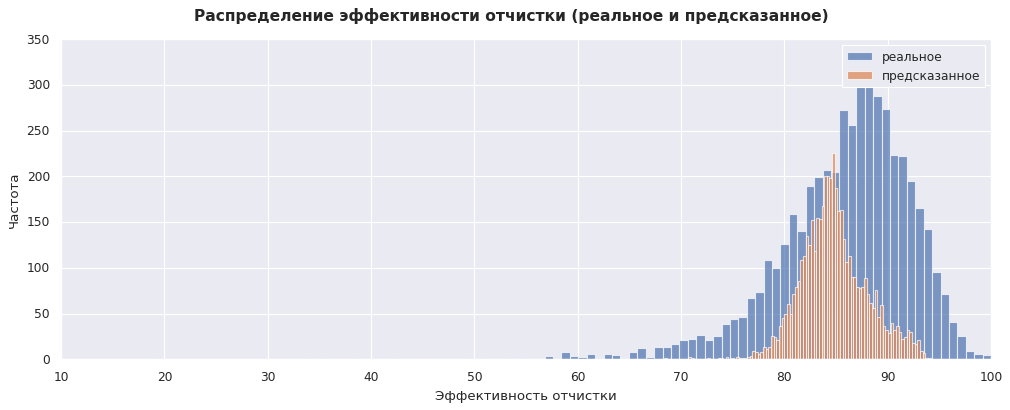

In [ ]:
#Гистограммы для суммарных концентраций
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
# Заголовок фигуры
fig.suptitle('Распределение эффективности отчистки (реальное и предсказанное)', fontsize=14, fontweight='bold');
axes.set_xlabel(f'Эффективность отчистки')
axes.set_ylabel('Частота')
lables = ['реальное','предсказанное']
for idx, predict in enumerate([ddict['test']['first_target_no_corr'], predict_1_recovery]):
    predict.plot(kind = 'hist', bins = 100, ax = axes, alpha = 0.7, label = lables[idx])
    axes.set_ylabel('Частота')
    axes.legend().set_visible(True)

###  Проверка второй модели на тестовой выборке

In [ ]:
best_model = ElasticNet(**params_2Es)
best_model.fit(ddict['train']['SS_second_features'],\
               ddict['train']['second_target'])
predict_2_recovery = \
pd.Series(best_model.predict(ddict['test']['SS_second_features']),\
                              index = ddict['test']['second_target'].index)
          
sMAPE_2 = calc_sMAPE(predict_2_recovery, ddict['test']['second_target'])
print(sMAPE_2)

series
8.11947089544052


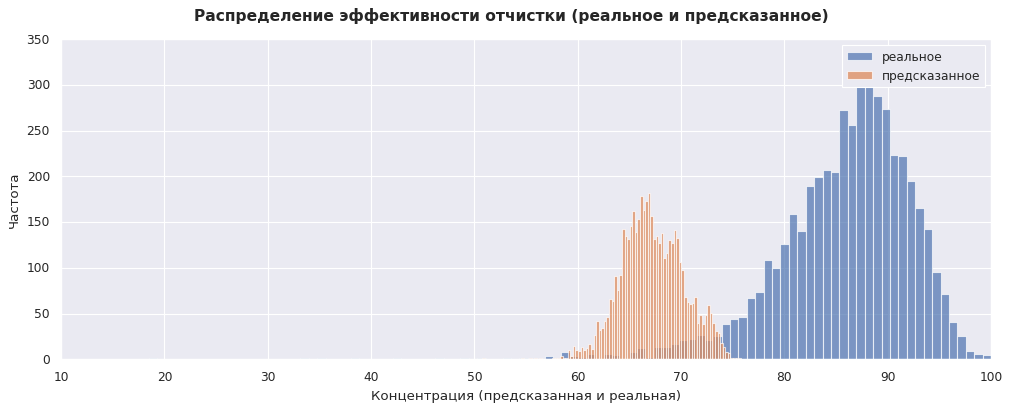

In [ ]:
#Гистограммы для суммарных концентраций
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
fig.suptitle('Распределение эффективности отчистки (реальное и предсказанное)', fontsize=14, fontweight='bold');
axes.set_xlabel(f'Эффективность отчистки')
axes.set_ylabel('Частота')
lables = ['реальное','предсказанное']
for idx, predict in enumerate([ddict['test']['first_target'], predict_2_recovery]):
    predict.plot(kind = 'hist', bins = 100, ax = axes, alpha = 0.7, label = lables[idx])
    axes.set_xlabel(f'Концентрация (предсказанная и реальная)')
    axes.set_ylabel('Частота');
    axes.legend().set_visible(True)

### Расчет суммарной sMAPE

In [ ]:
sMAPE = calc_final_sMAPE(sMAPE_1, sMAPE_2)
print(sMAPE)

7.3362645163939595


### Проверка адекватности моделей (dummy)

In [ ]:
#Первая модель
first_dummy_model = DummyRegressor(strategy="mean")
first_dummy_model\
.fit(ddict['train']['SS_first_features'], ddict['train']['first_target'])
first_predict = first_dummy_model.predict(ddict['test']['SS_first_features'])
dummy_sMAPE_1 = calc_sMAPE(\
                           pd.Series(first_predict, index = ddict['test']['first_target'].index),\
                           ddict['test']['first_target'])


#Вторая модель
second_dummy_model = DummyRegressor(strategy="mean")
second_dummy_model\
.fit(ddict['train']['SS_second_features'], ddict['train']['second_target'])
second_predict = second_dummy_model.predict(ddict['test']['second_features'])
dummy_sMAPE_2 = calc_sMAPE(\
                           pd.Series(second_predict, index = ddict['test']['second_target'].index),\
                           ddict['test']['second_target'])


#Суммарная ошибка
dummy_sMAPE = calc_final_sMAPE(dummy_sMAPE_1, dummy_sMAPE_2)
print(dummy_sMAPE)

series
series
8.46949558502249


## Выводы по результатам исследования

Целью исследования было снизить риски внедрения неэфективных процессов обработки золотодобывающего сырья за счет оценки(предсказания) эффективности очистки сырья блоками оборудования с заданными характеристика, которые должны быть выполнены машинной моделью. Модель должна была быть разработана на основании исследования исторических данных об обработке золотосодержащего сырья (характеристики сырья, настроек оборудования, итоговых продуктов) и предсказывать(расчитывать) эффективность золотообагощения на двух стадиях (после флотации и после итоговой очистки). Показателем качества модели требовалось принять sMAPE, которая должна быть как можно меньше.

В процесе исследования:
1. Загружены и изучены исторические данные о параметрах технологических установок золотообработки
2. Загруженные данные трех ДФ (тренировочного, тестового, полного) оценены, определена их форма, типы, смысловая нагрузка
3. Выполнена предъобработка, включая:
     - проверку и переименование названий столбцов (приведение к стилю under_score)
     - проверку корректности назначенных типов данных (изменен столбец с датой)
     - поиск полных и неявных дубликатов (не выявлено) 
     - поиск и заполнение пропусков (во всехстолбцах найдены и заполненены методом скользящего окна с размером в сутки(неделю) пропуски c контролем статистических характеристик изменяемых признаков)
     - выявление аномальных значений (выявлены записи с нулевыми значениями суммарных консентраций и выбросы в размерах гранул сырья, содержащие их записи исключены из ДФ)
     - удаление неинформативных столбцов, затрудняющих обучение моделей (все столбцы с префиксами calculation и столбец date (непосредственно перед обучением))
     - поиск коррелированых столбцов (выявлено значительное кол-во неоднократно коррелированных между собой столбцов, созданы отдельные ДФ, отчищенные от корреляции)
     - объединение всех ДФ(тренировочного, тестового, полного) в единый словарь (для автоматизации)

4. Проведено исследование данных на предмет применимости для машинного обучения
  - изучены признаки и целевые показатели,  определена принадлежность признаков к одной из трех возможных стадий обработки (флотация, первичная очистка, вторичная очистка)
  - сформированы списки признаков для машинных моделей:
      - первой, расчитывающей эффективность очистки после флотации
      - второй, расчитыающей эффективность очистки после финальной очистки
  - проведено исследование изменений концентраций металлов в сырье от стадии к стадии, построены и проанализированы распределения плотностей вероятности для каждого металла, типа сырья (входное сырье, получившийся продукт, шаг обработки)
  - выявлены следующие закономерности:
      - концентрация золота показывает ожидаемую тенденцию к увеличению в итоговом продукте и относительно стабильную низкую величину в хвостах,
      - концентрация серебра показывает ожидаемую тенденцию к уменьшению в итоговом продукте и небольшому увеличению в хвостах,
      - концентрация свинца показывает неожиданную тенденцию к увеличению в итоговом продукте (видимо за счет уменьшения концентрации другого МУСОРА, данных по которому у нас нет) и ожидаемое увеличение в хвостах,
      - концентрация шлака показывает ожидаемую тенденцию к уменьшению в итоговом продукте и неожидаенное уменьшение в хвостах (за счет значительного увеличение в хвостах концентрации другого МУСОРА),
  - исследованы суммарные концентрации сырья
  - проведено сравнение распределений размеров гранул (графически, критерий Манна-Уитни), 
  - для повышения качества и стабильности предсказаний, сокращения различий между размерами гранул в тестовой и тренировочной выборках внесены ограничения модели по размеру гранул(от 20 до 120 условных единиц)
  - проведена стандартизация количественных признаков методом preprocessing.StandartScaler
5. Подтотовлен комплект функций, автоматизирующих:
 - расчет sMAPE, суммарного sMAPE
 - выявление мультиколлерированных столбцов
 - перебор гиперпараметров моделей с/без кроссвалидации
 - выбор лучшей модели для разных комбинаций гиперпараметров, где лучшей считается модель с наименьшим значением sMAPE на тренировочной выборке

6. Проведено машинное обучение с учителем на моделях регрессии:
- модель Lasso
- модель Ridge
- модель DecisionTreeClassifier
- модель LogisticRegression (лог-регрессия)
- ElasticNet

7. Выполнено:
   - обучение всех моделей на исходном ДФ (с кроссвалидацией)
   - обучение всех моделей на ДФ со стандартизацией признаков (с кроссвалидацией)
   - обучение всех моделей на отчищенном от корреляции ДФ без стандартизации (с кроссвалидацией)
   - обучение всех моделей на отчищенном от корреляции ДФ и стандартизированном ДФ (с кроссвалидацией)
   - проверка двух наиболее оптимальных моделей (ElasticNet) на тестовой выборке (без кроссвалидации)
   - расчет этапных и суммарной метрики sMAPE
   - проверка моделей на адеватность с применением моделей DummyClassifier
   
8. По результатам обучения и сравнения моделей можно отметить следующее.
   1. Применение кроссвалидации позволило эффективно решить проблему переобучения
   2. Исключение мультиколлинеарности не принесло ожидаемого эффекта (почти все модели после исключения столбцов продеманстрировали худшие результаты)
   3.Стандартизация также не привела к повышению качества моделей
   4. Метрика sMAPE не зависит от регуляризации данных
   5. Итоговые показатели качества лучших моделей:
    - после флотации = 8.662766982398082
    - после финальной очистки = 8.680752761229549
    - суммарный = 8.478665205751911
    
9. Как можно доработать проект:
- пропробовать применить другие методы обработки пропусков (ближайшие соседи KNNImputer, алгоритм MICE IterativeImputer, c использованием линейной регрессии https://www.dmitrymakarov.ru/data-analysis/nan-06/#33-sklearn-knnimputer), 
- попробовать проанализировать графики зависмости эффективности отчистки от каждого из признаков, выделить те из них, на которых зависимость проявляется наиболее ярко и оставить только эти признаки в выборке фичерсов (или увеличить для них весовые коэффициенты),
- попробовать применить другие методы масштабирования(регуляризации): полиноминальные (PolynomialFeatures), логарифмирование и взятие квадратного корня от признаков, трансформация Бокса-Кокса (boxcox) (https://nagornyy.me/it/regressionnye-modeli-v-python/),
- попробовать округлить все признаки до целых значений и применить линейную модель случайного дерева
- проиллюстрировать результативность предсказаний модели графиком Residuals plot (связь между остатками модели и предсказанными значениями),
- наприсовать графики прогресса обагощения на этапе исследования концентраций,
- сделать подписи к строкам прогресса (tqdm)